In [1]:
import dpkt
import os
import pandas as pd
from utils.util import create_directory_if_not_exists, find_files_with_extension
from utils.plotter import plot_siftr_graph
import numpy as np


# Convert bytes to Mbit/s
def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

# Read pcap file and get throughput per second for specific ports
def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}}
    total_throughput = {5101: 0, 5102: 0, 5103: 0}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)

            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)

            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
            total_throughput[dest_port] += pkt_length

    return throughput_per_second , total_throughput



def udp_read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}}
    total_throughput = {5101: 0, 5102: 0, 5103: 0}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.udp.UDP):  # Check for UDP instead of TCP
                continue

            udp = ip.data
            dest_port = udp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)

            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)

            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
            total_throughput[dest_port] += pkt_length

    return throughput_per_second, total_throughput




# Plot throughput using plot_siftr_graph
def plot_throughput_with_siftr(file_path, ycolumn, title, xlabel, ylabel, filename, graph_directory):

    if "udp" in filename:
        throughput, total_thrpt = udp_read_pcap(file_path)
    else:
        throughput, total_thrpt = read_pcap(file_path)
    paths = {}
    print(f"Total throughput for {filename}: {total_thrpt}")

    for port, data in throughput.items():
        # Sort throughput dictionary by time
        sorted_throughput = sorted(data.items())

        # Prepare time and throughput values
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]

        print("len(mbits_transferred): ", len(mbits_transferred))
        print("np.mean(mbits_transferred): ", np.mean(mbits_transferred))

        if len(mbits_transferred) < 10 or np.mean(mbits_transferred) < 0.5:
            print(f"Port {port} has low throughput. Skipping...")
            continue
        else:
            print(f"Port {port} has good throughput. Plotting...")

        

            # Create a DataFrame for each port
            path_df = pd.DataFrame({'Time': times, ycolumn: mbits_transferred})
            path_label = f"Port {port}"
            if port == 5101:
                if "New Reno" in filename:
                    path_label = "New_Reno"
                if "udp" in filename:
                    path_label = "udp"

            # elif port == 5102: 
            #     path_label = "New Reno"
            # elif port == 5103:
            #     path_label = "DCTCP"
            # Store the DataFrame in the paths dictionary
            paths[path_label] = path_df

            # Ensure the output directory exists
            create_directory_if_not_exists(graph_directory)

            # Call the plot_siftr_graph function to plot the graph
            plot_siftr_graph(paths, ycolumn, title, xlabel, ylabel, filename, graph_directory)

# Main execution
mainpth="../data/data_2025-03-19-01-12-25"
graph_directory = os.path.join(mainpth, "Graphs")
create_directory_if_not_exists(graph_directory)

folderpath = os.path.join(mainpth, "server_data")

# Use the new find_files_with_extension function
filenames, filepaths, file_dict = find_files_with_extension(paths=[folderpath], extension='.em1.pcap')

from utils.thrpt_util import analysis_pcap_tcp

Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


In [2]:
# # Plot throughput for each pcap file
# for filename, filepath in zip(filenames, filepaths):
#     print(filename)
#     analysis_pcap_tcp(filepath)

Total throughput for 1_fq_codel_10Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1213, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.004852
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3894746, 5102: 0, 5103: 0}
len(mbits_transferred):  29
np.mean(mbits_transferred):  1.0744126896551724
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


c:\Users\deols\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\deols\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


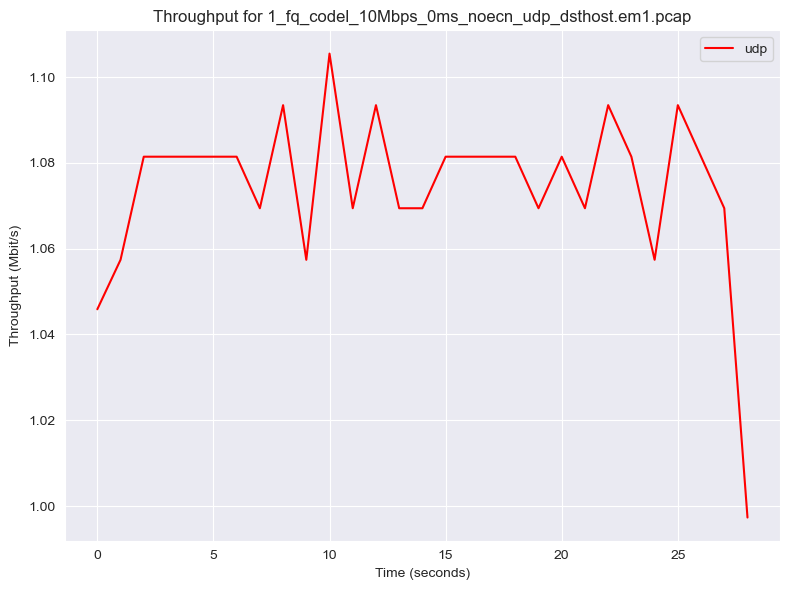

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1147, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.004588
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2334168, 5102: 0, 5103: 0}
len(mbits_transferred):  18
np.mean(mbits_transferred):  1.037408
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


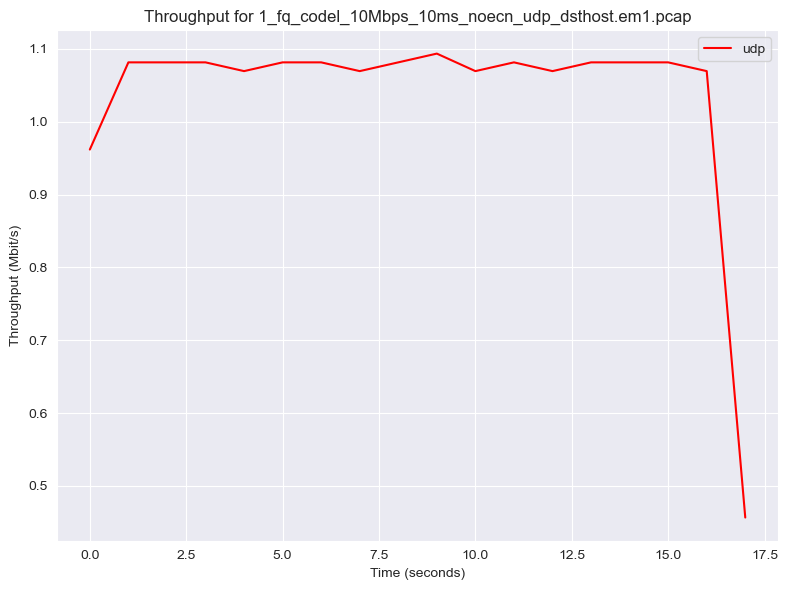

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2197486, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0341110588235292
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


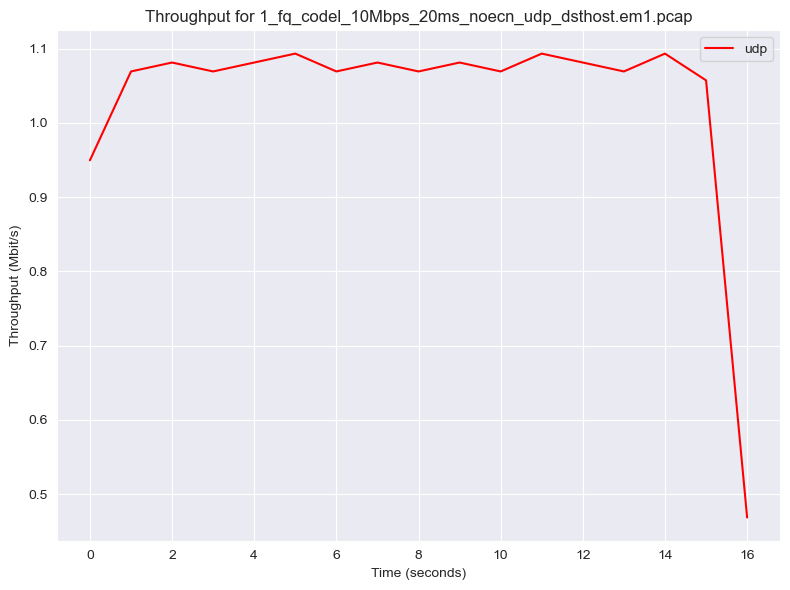

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 4732862, 5102: 0, 5103: 0}
len(mbits_transferred):  36
np.mean(mbits_transferred):  1.0517471111111112
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


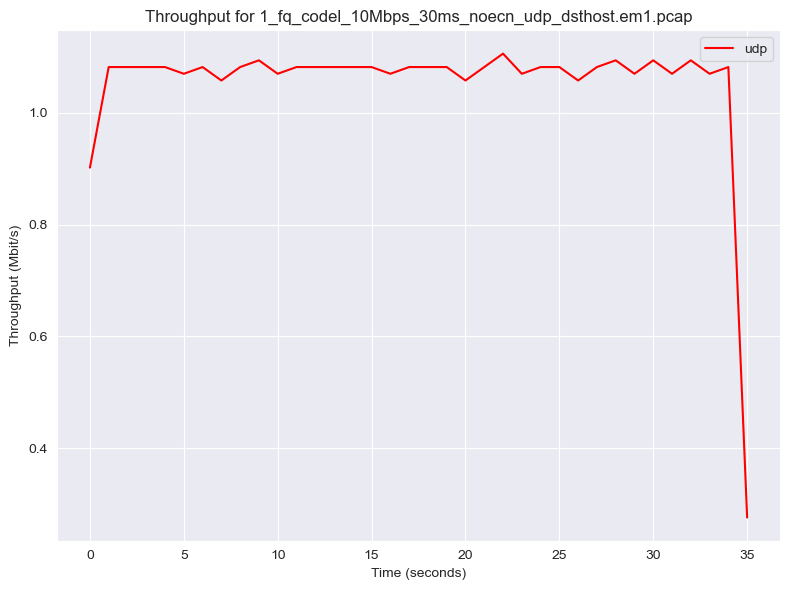

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1146, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.003056
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_10Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2156932, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0150268235294118
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


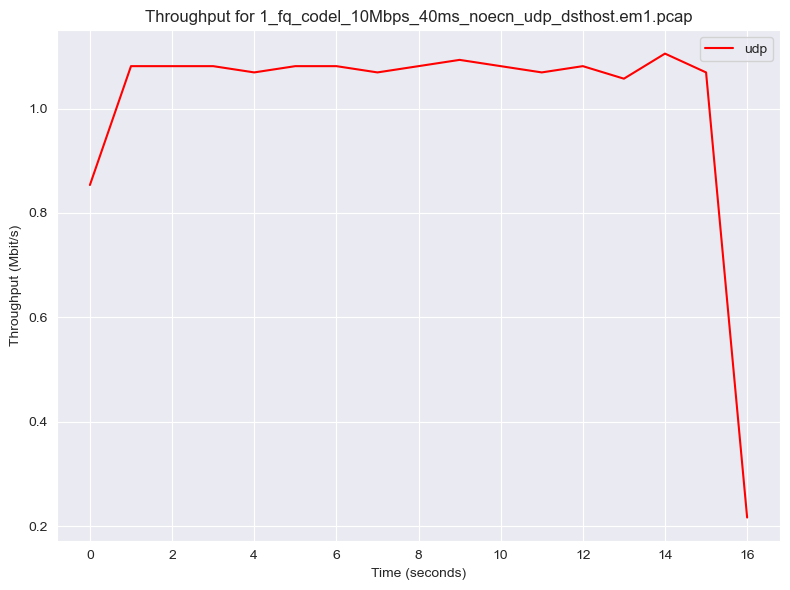

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 56812260, 5102: 0, 5103: 0}
len(mbits_transferred):  121
np.mean(mbits_transferred):  3.756182479338843
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


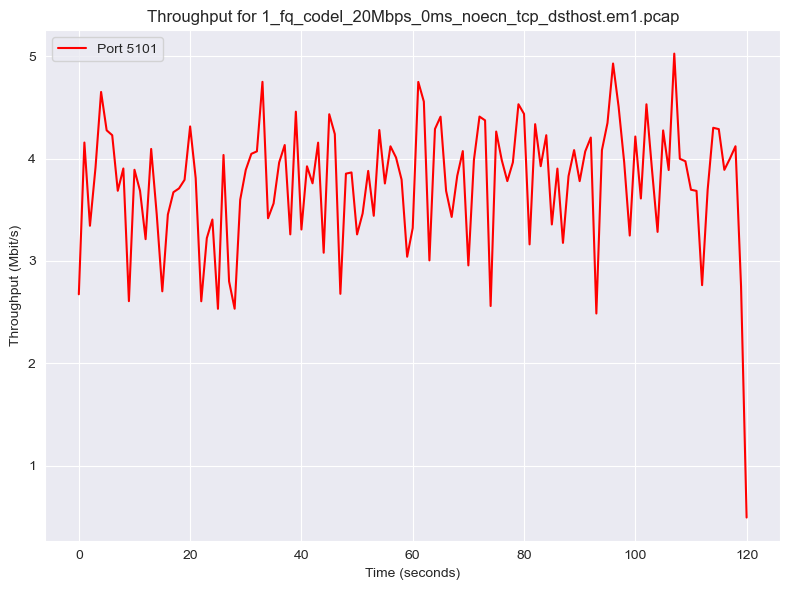

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 5631058, 5102: 0, 5103: 0}
len(mbits_transferred):  42
np.mean(mbits_transferred):  1.0725824761904759
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


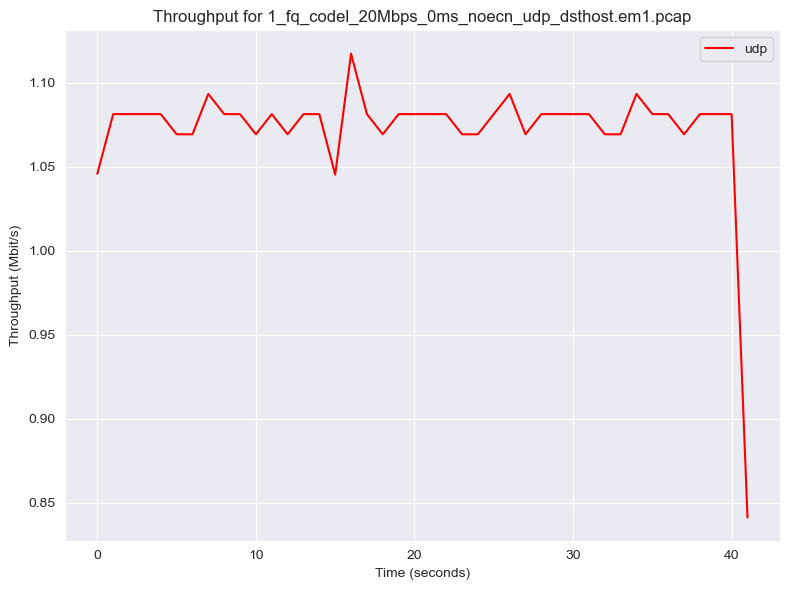

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 59796466, 5102: 0, 5103: 0}
len(mbits_transferred):  122
np.mean(mbits_transferred):  3.9210797377049182
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


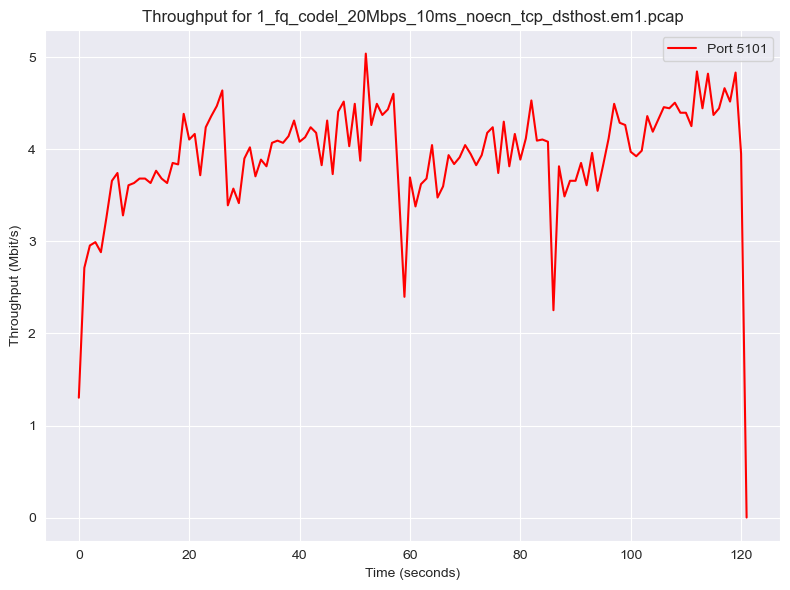

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2350690, 5102: 0, 5103: 0}
len(mbits_transferred):  18
np.mean(mbits_transferred):  1.044751111111111
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


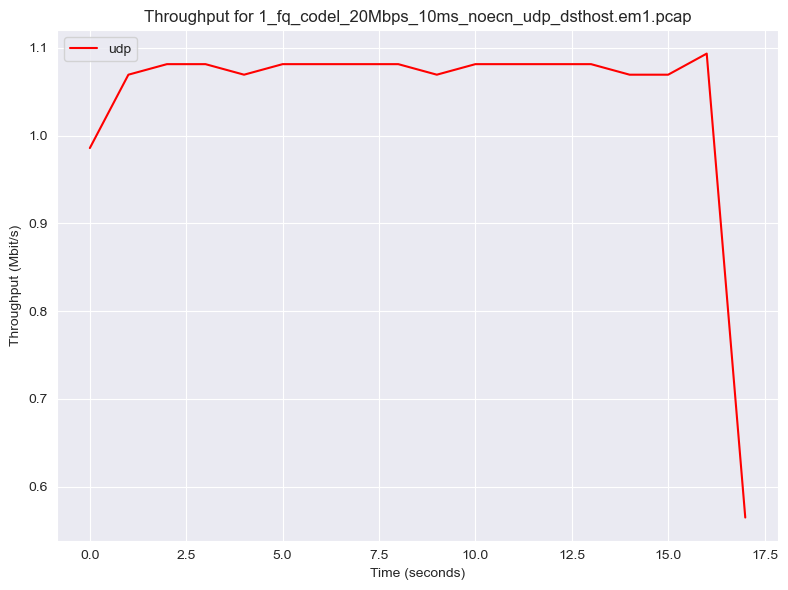

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1215, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.00486
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 4638236, 5102: 0, 5103: 0}
len(mbits_transferred):  35
np.mean(mbits_transferred):  1.0601682285714285
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


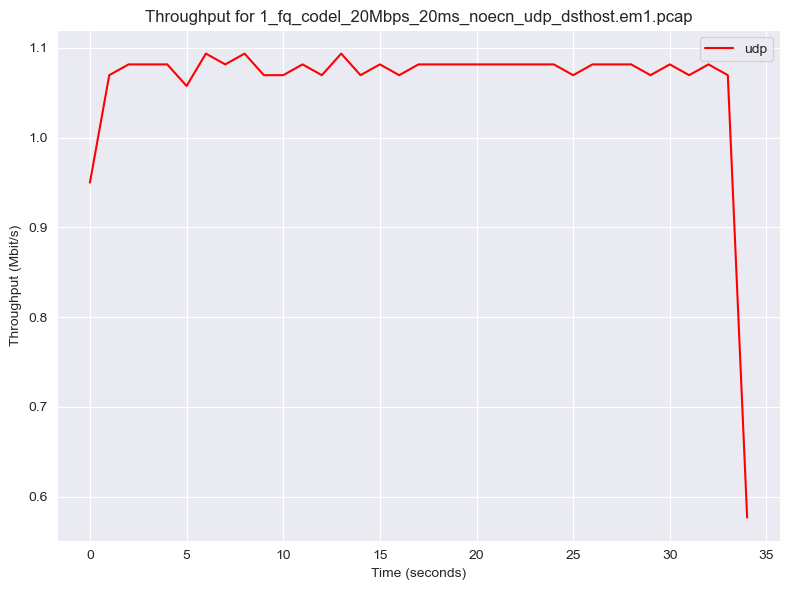

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1149, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.004595999999999999
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3800120, 5102: 0, 5103: 0}
len(mbits_transferred):  29
np.mean(mbits_transferred):  1.0483089655172415
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


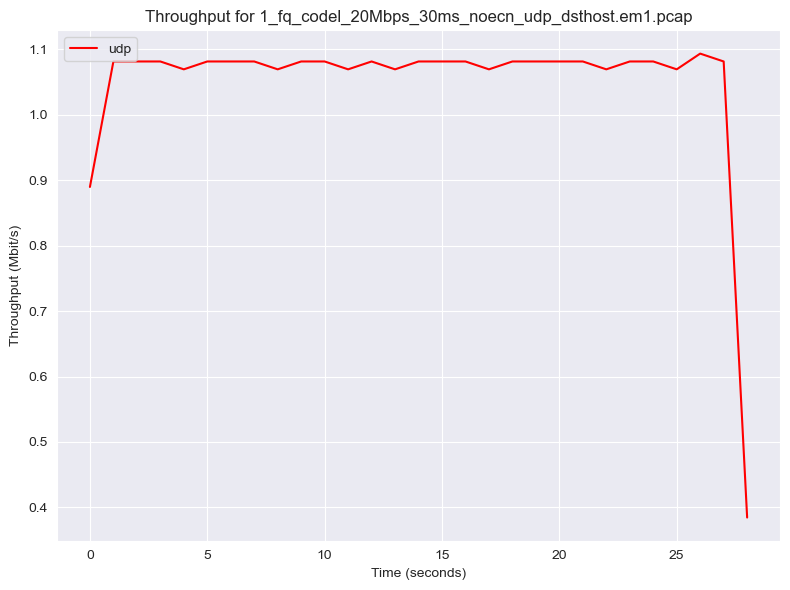

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1149, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.0030639999999999994
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_20Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 5524416, 5102: 0, 5103: 0}
len(mbits_transferred):  42
np.mean(mbits_transferred):  1.0522697142857143
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


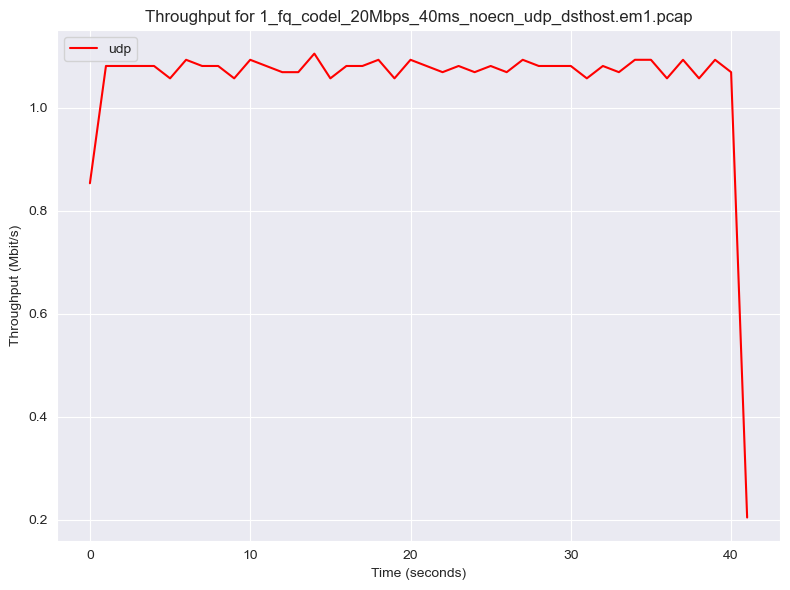

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1215, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.00486
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2257566, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0623839999999998
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


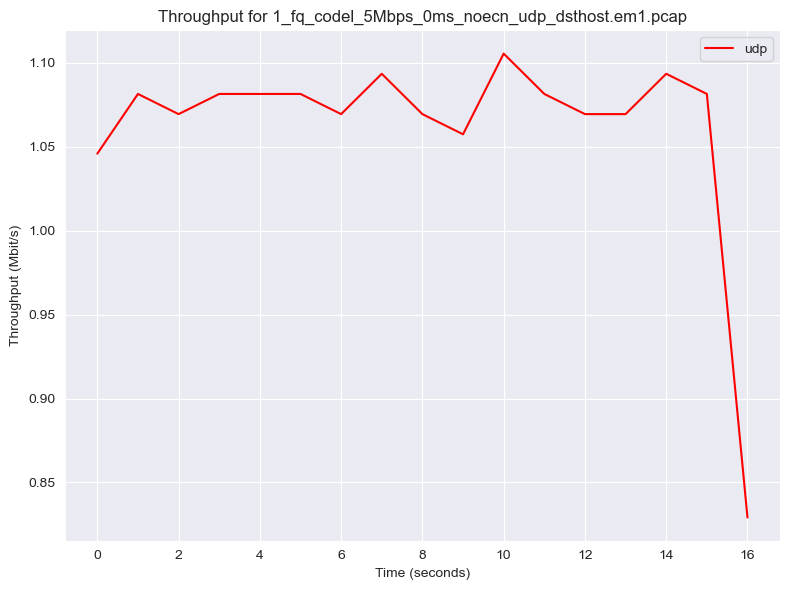

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1147, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.0030586666666666666
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 1407434, 5102: 0, 5103: 0}
len(mbits_transferred):  11
np.mean(mbits_transferred):  1.0235883636363636
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


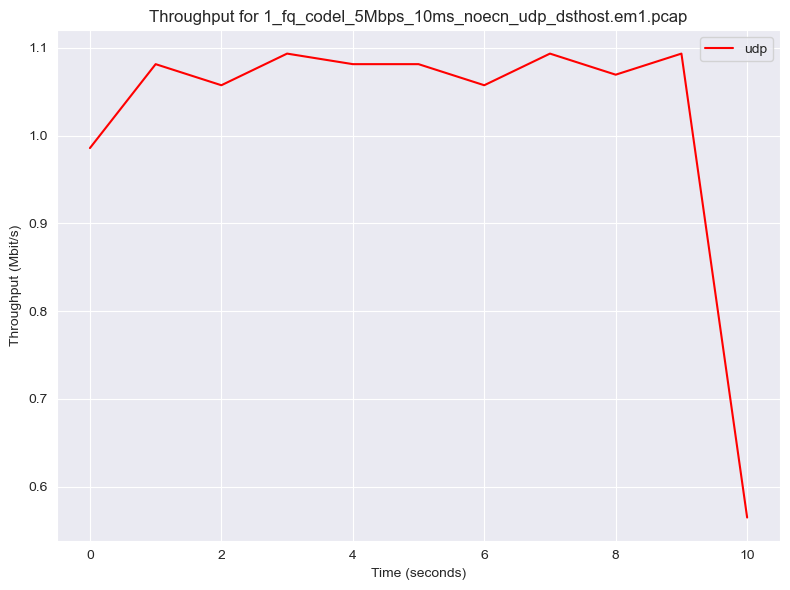

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1273, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.003394666666666667
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2990542, 5102: 0, 5103: 0}
len(mbits_transferred):  23
np.mean(mbits_transferred):  1.0401885217391307
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


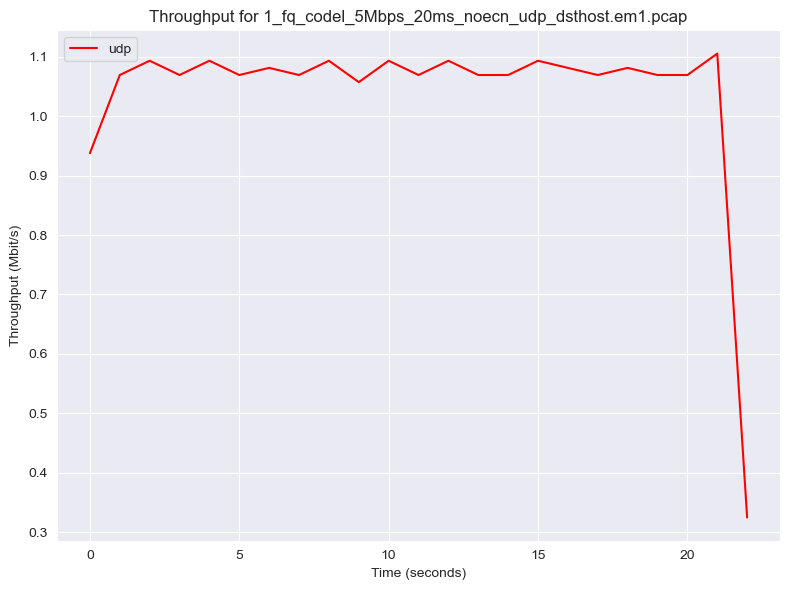

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 28981369, 5102: 0, 5103: 0}
len(mbits_transferred):  123
np.mean(mbits_transferred):  1.8849670894308945
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


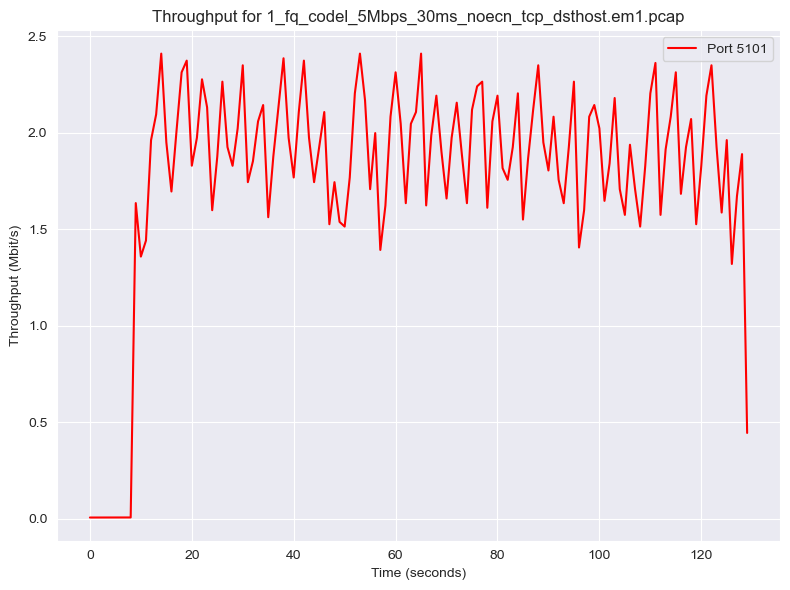

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2164442, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0185609411764704
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


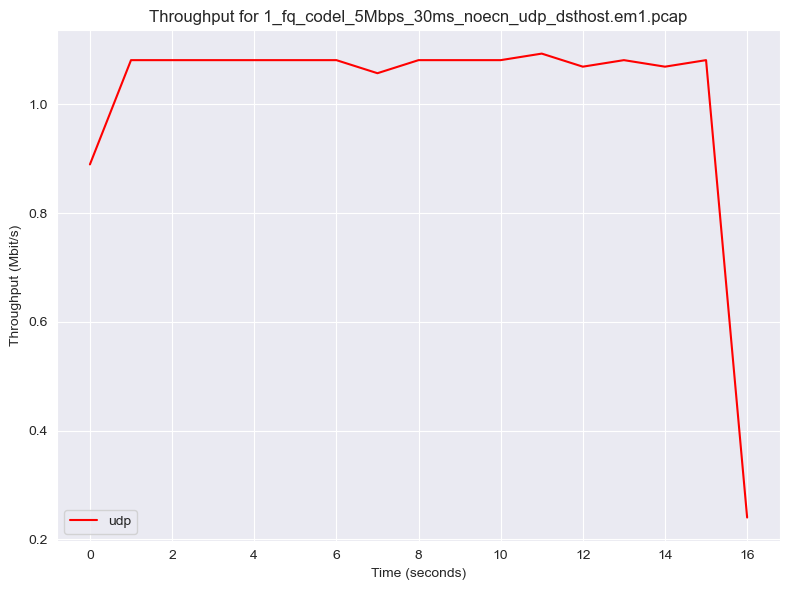

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_5Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 4593176, 5102: 0, 5103: 0}
len(mbits_transferred):  35
np.mean(mbits_transferred):  1.0498688
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


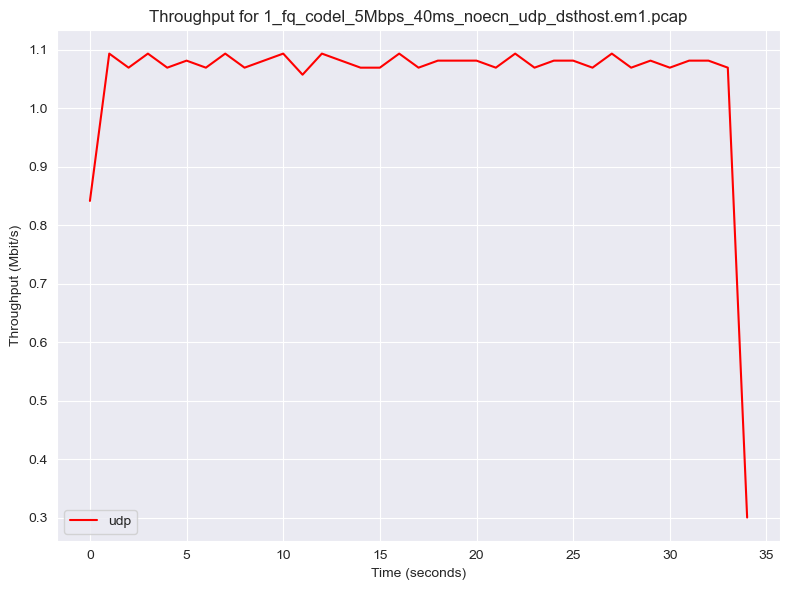

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1281, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.005124
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3076156, 5102: 0, 5103: 0}
len(mbits_transferred):  23
np.mean(mbits_transferred):  1.0699673043478262
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


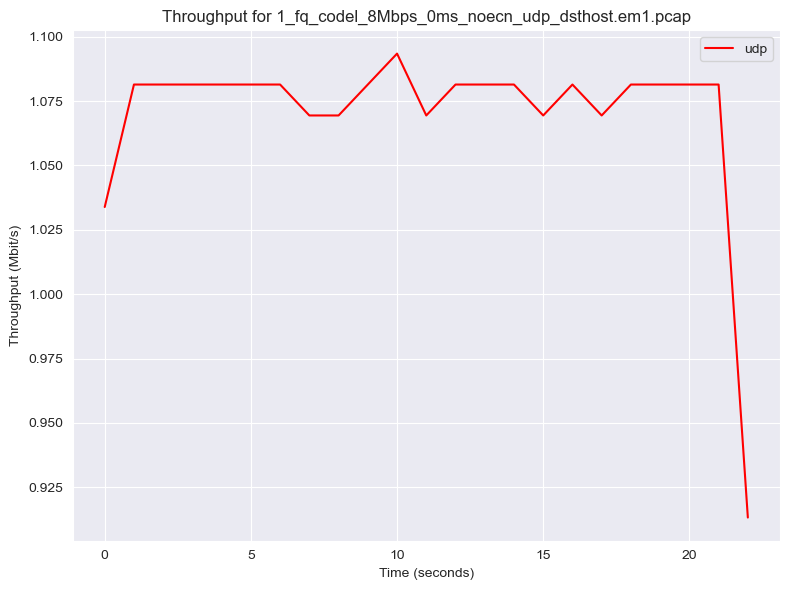

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1147, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.004588
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 5470344, 5102: 0, 5103: 0}
len(mbits_transferred):  41
np.mean(mbits_transferred):  1.067384195121951
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


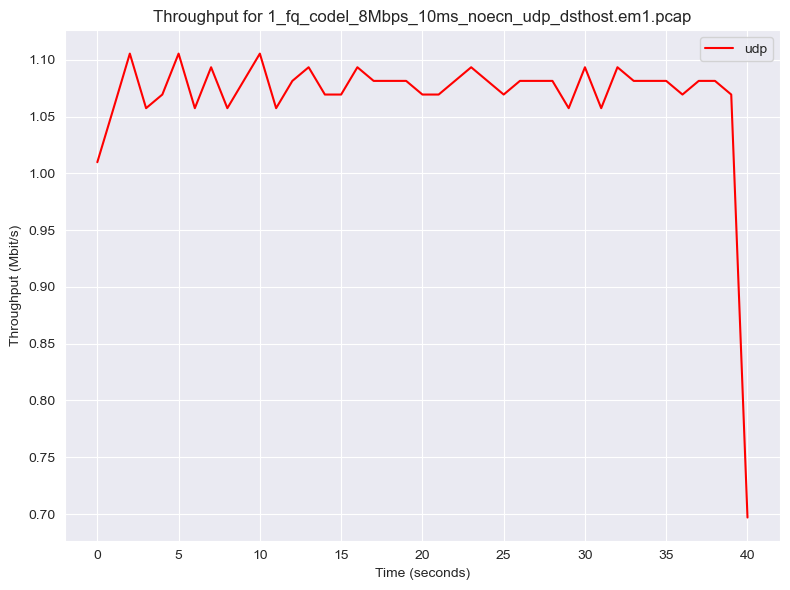

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 42926164, 5102: 0, 5103: 0}
len(mbits_transferred):  122
np.mean(mbits_transferred):  2.8148304262295083
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


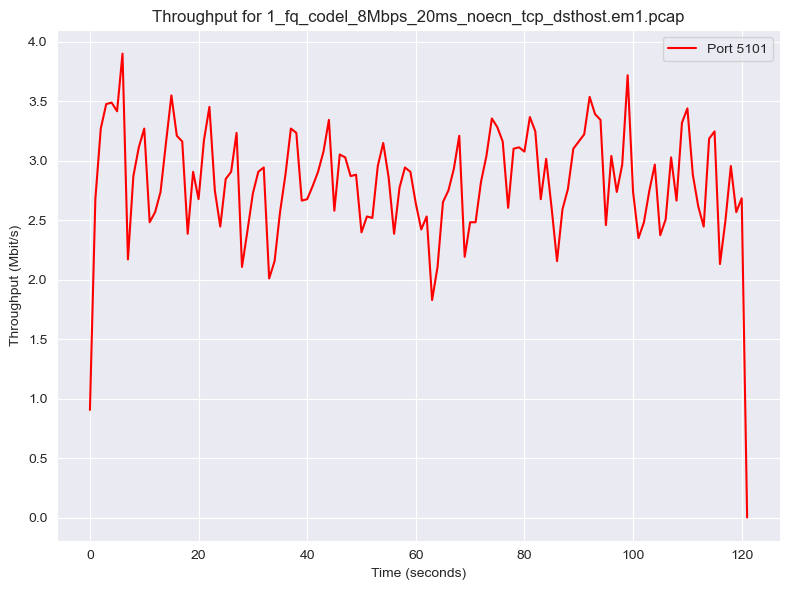

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3816642, 5102: 0, 5103: 0}
len(mbits_transferred):  29
np.mean(mbits_transferred):  1.05286675862069
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


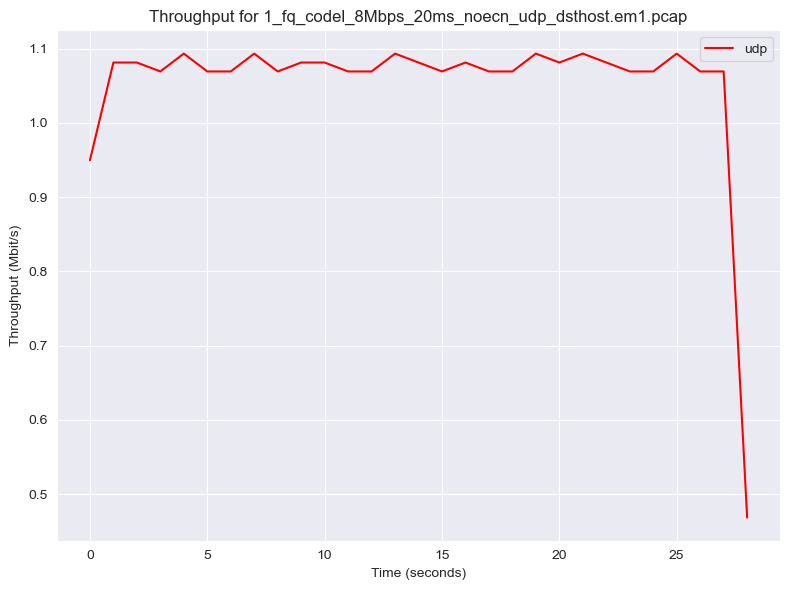

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1214, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.004856
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3929292, 5102: 0, 5103: 0}
len(mbits_transferred):  30
np.mean(mbits_transferred):  1.0478112000000002
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


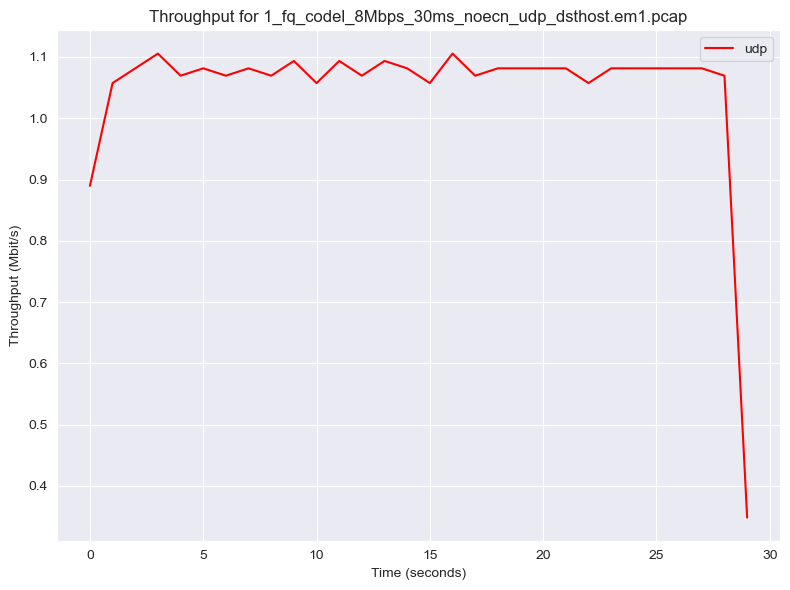

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_fq_codel_8Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 4579658, 5102: 0, 5103: 0}
len(mbits_transferred):  35
np.mean(mbits_transferred):  1.0467789714285713
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


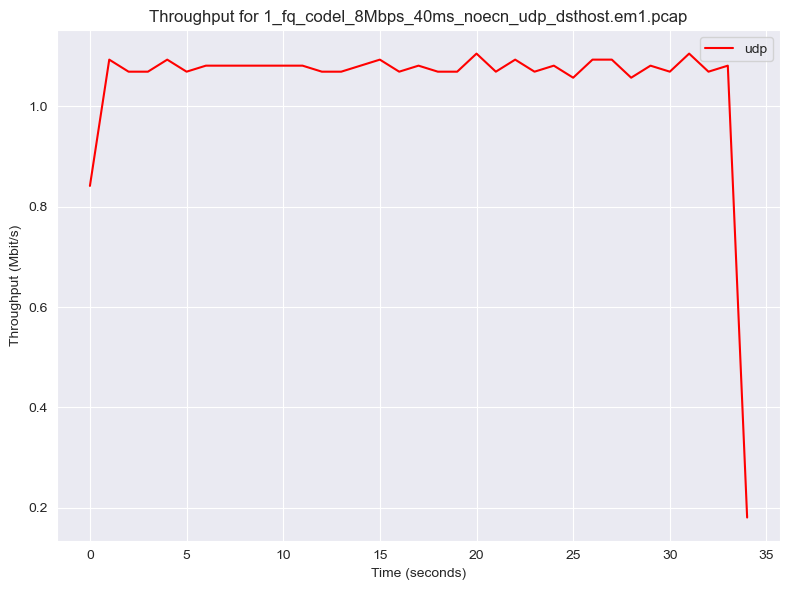

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 30377372, 5102: 0, 5103: 0}
len(mbits_transferred):  121
np.mean(mbits_transferred):  2.0084212892561983
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


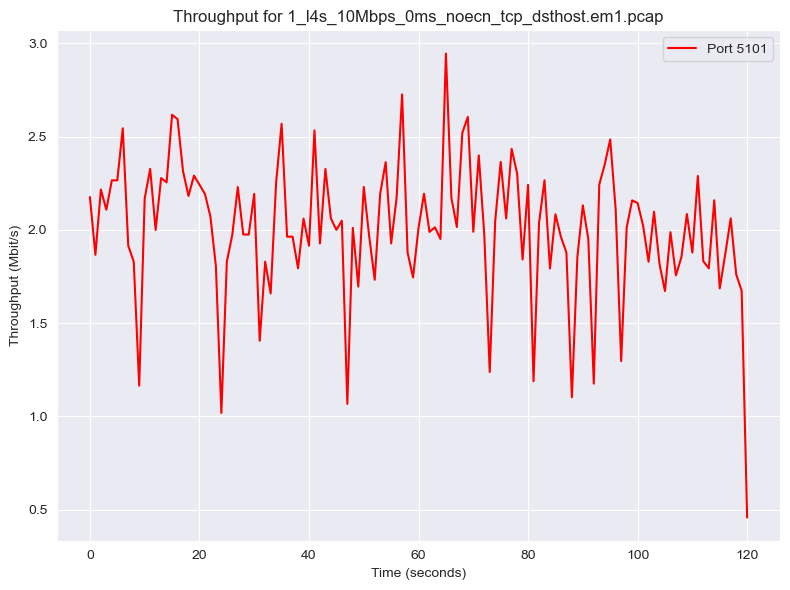

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 1435972, 5102: 0, 5103: 0}
len(mbits_transferred):  11
np.mean(mbits_transferred):  1.0443432727272728
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


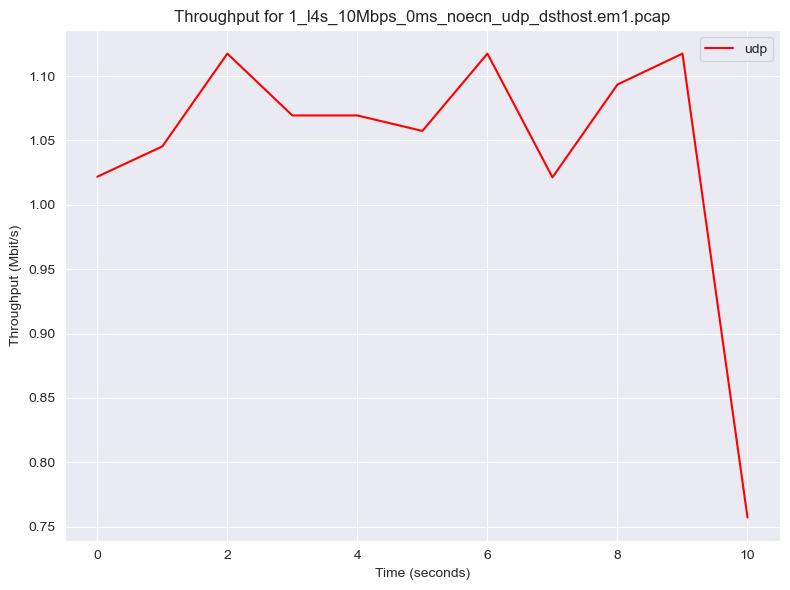

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2990482, 5102: 0, 5103: 0}
len(mbits_transferred):  23
np.mean(mbits_transferred):  1.0401676521739132
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


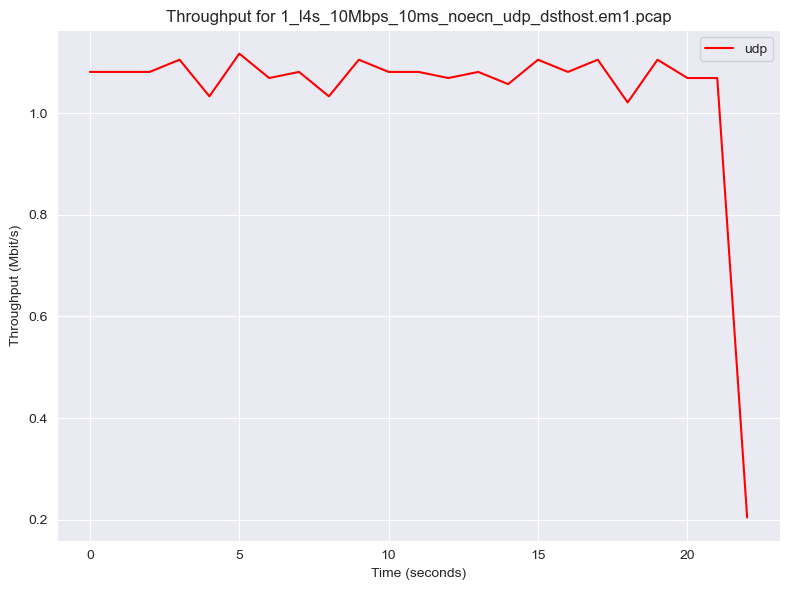

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 37483707, 5102: 0, 5103: 0}
len(mbits_transferred):  124
np.mean(mbits_transferred):  2.418303677419355
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


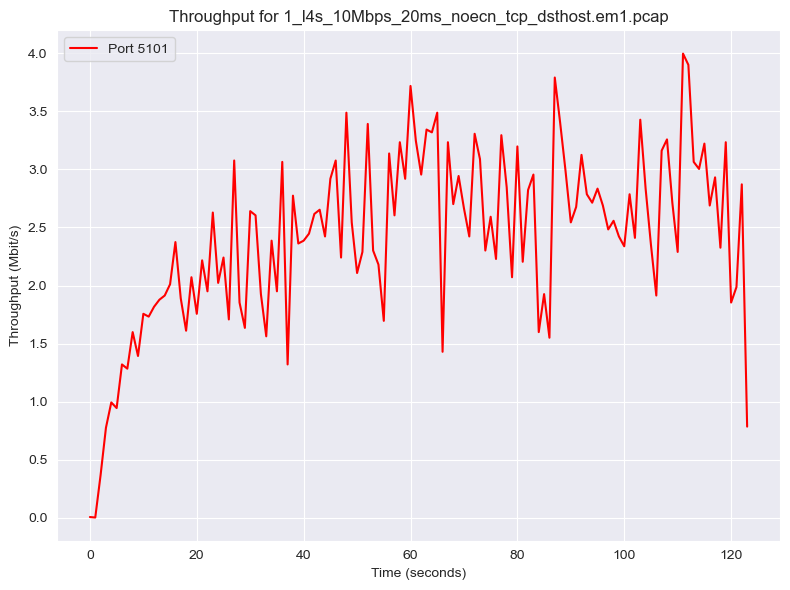

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2284602, 5102: 0, 5103: 0}
len(mbits_transferred):  18
np.mean(mbits_transferred):  1.0153786666666667
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


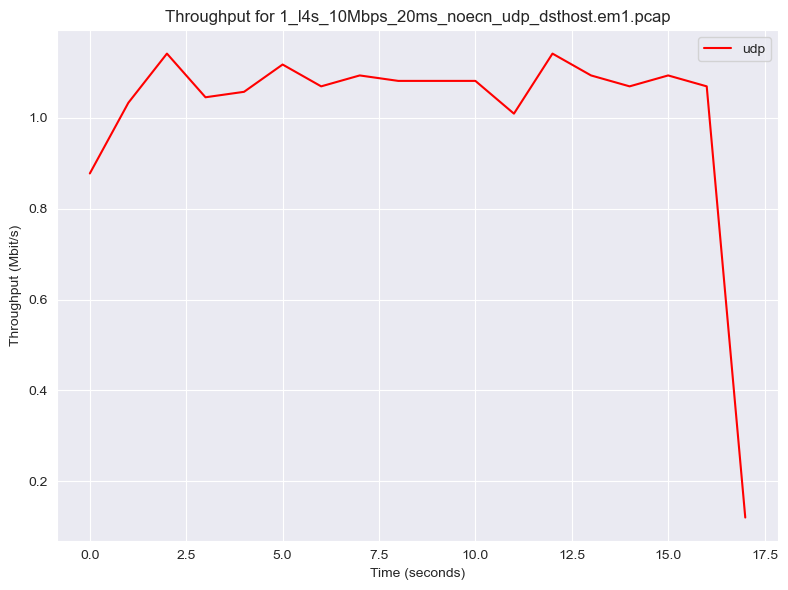

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2167386, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0199463529411765
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


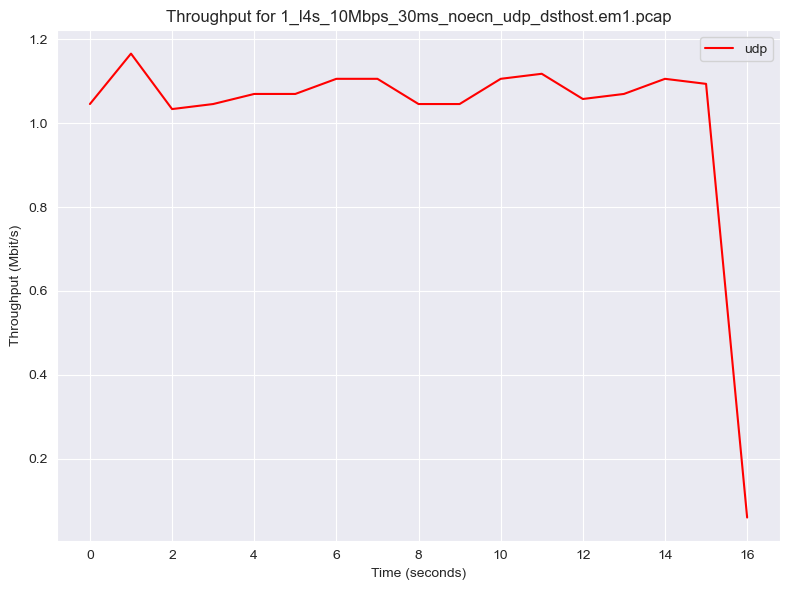

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 33060014, 5102: 0, 5103: 0}
len(mbits_transferred):  124
np.mean(mbits_transferred):  2.132904129032258
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


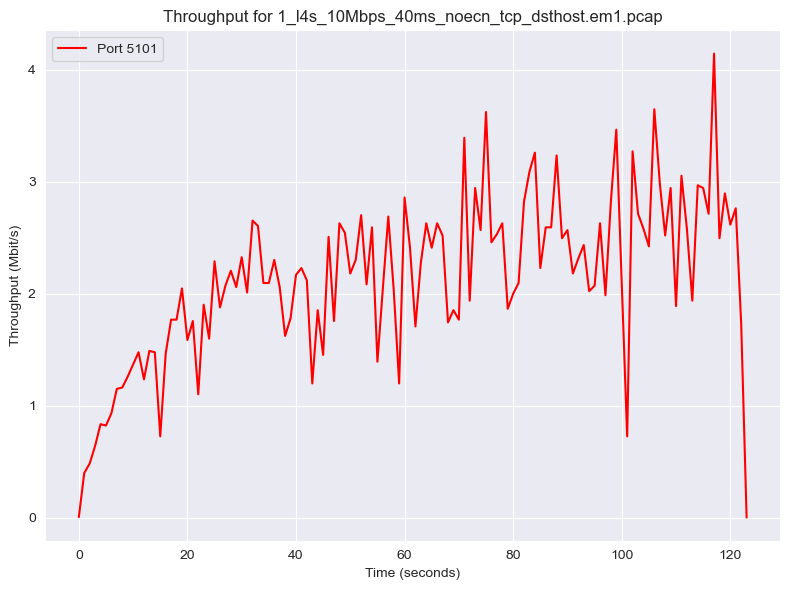

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_10Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3753558, 5102: 0, 5103: 0}
len(mbits_transferred):  29
np.mean(mbits_transferred):  1.0354642758620691
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


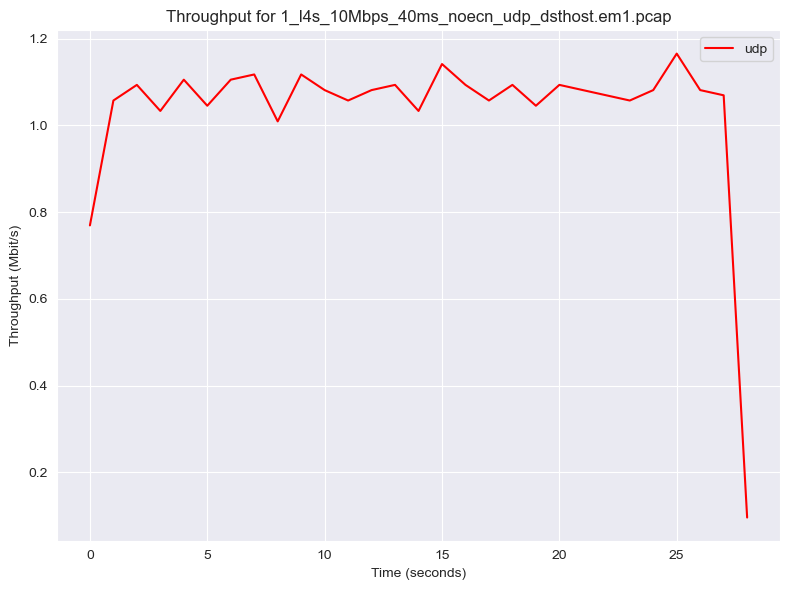

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 441, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003528
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2221518, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0454202352941178
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


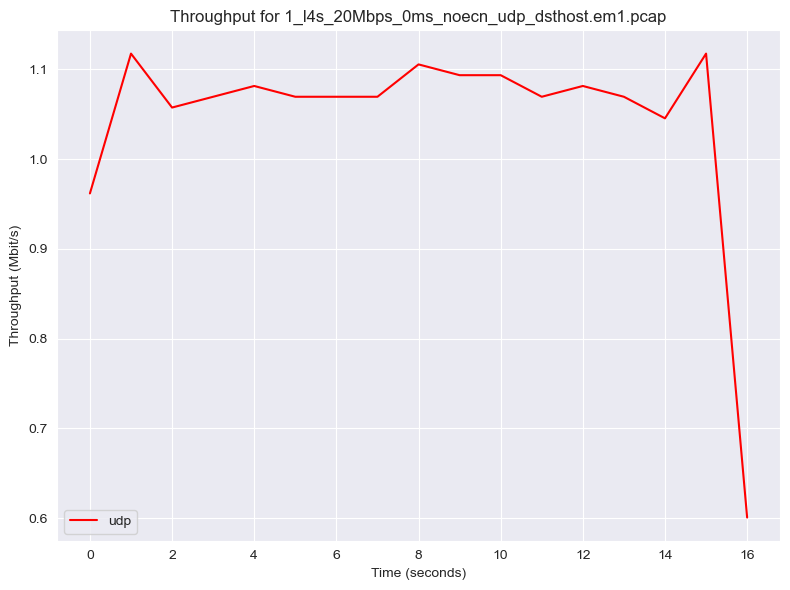

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 49180774, 5102: 0, 5103: 0}
len(mbits_transferred):  122
np.mean(mbits_transferred):  3.2249687868852455
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


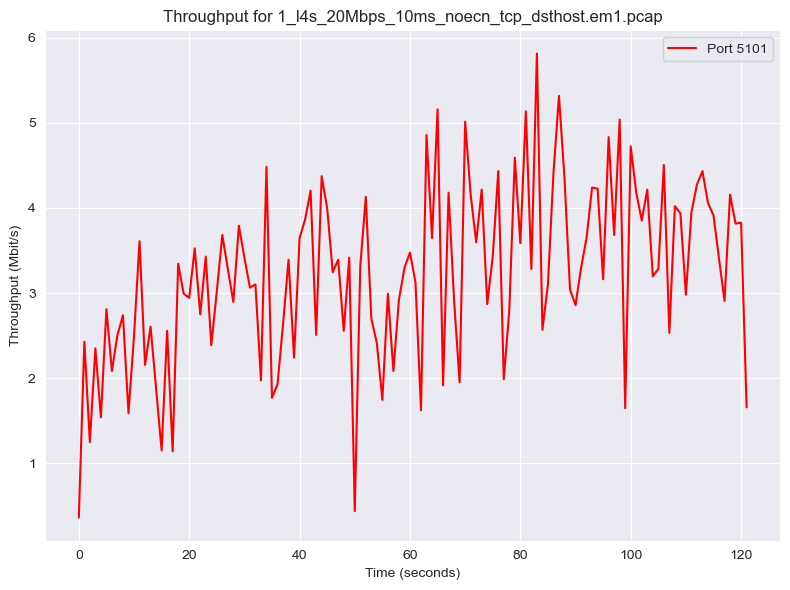

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3019080, 5102: 0, 5103: 0}
len(mbits_transferred):  23
np.mean(mbits_transferred):  1.0501147826086956
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


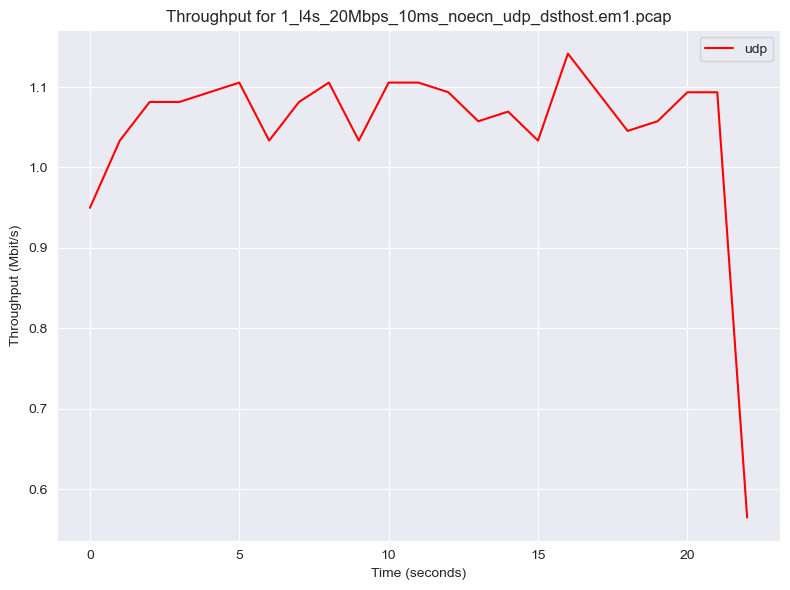

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2158374, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0157054117647057
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


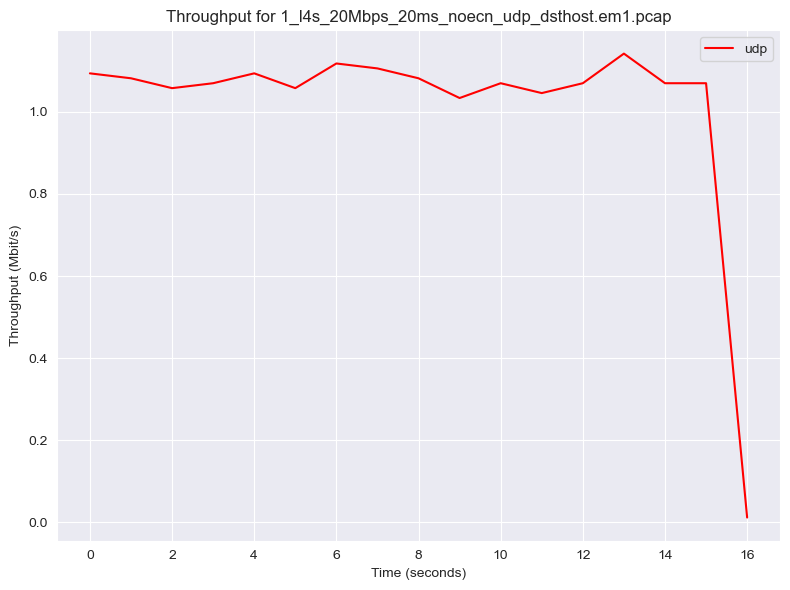

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 42858460, 5102: 0, 5103: 0}
len(mbits_transferred):  124
np.mean(mbits_transferred):  2.7650619354838706
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


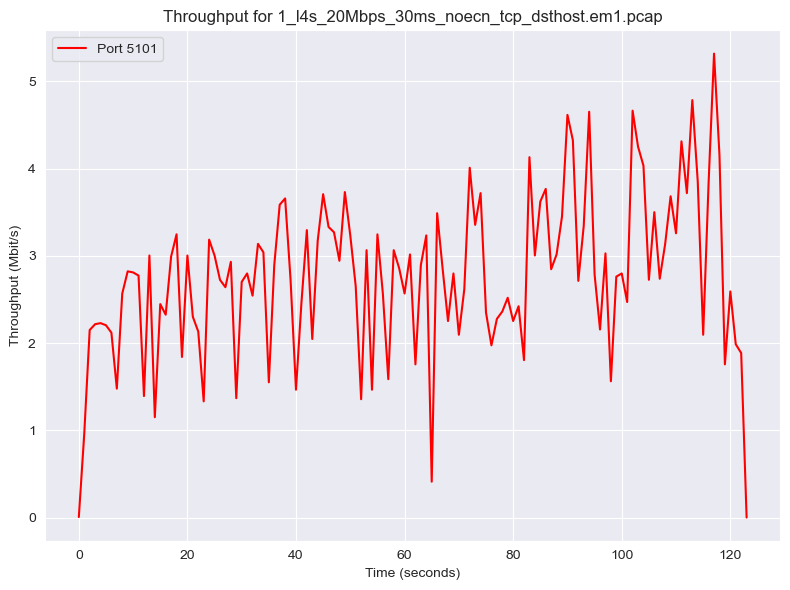

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2817812, 5102: 0, 5103: 0}
len(mbits_transferred):  22
np.mean(mbits_transferred):  1.0246589090909093
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


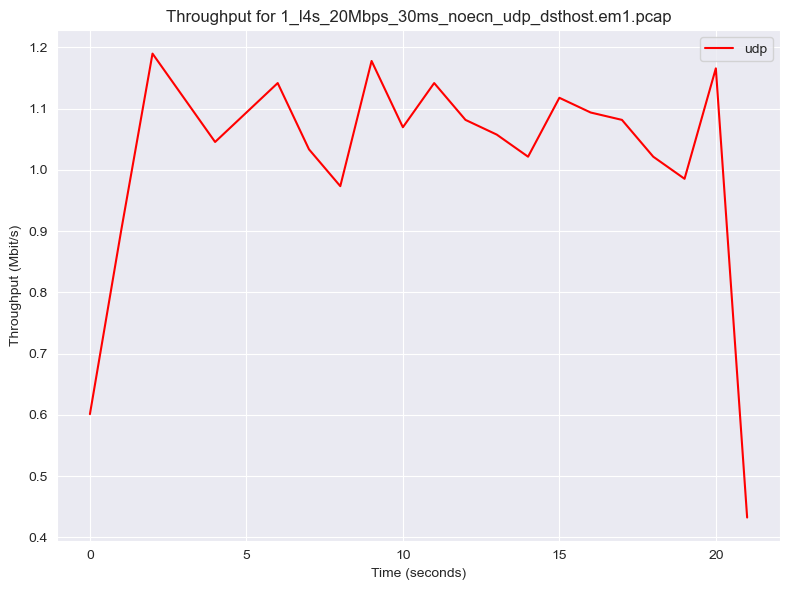

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_20Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2895916, 5102: 0, 5103: 0}
len(mbits_transferred):  22
np.mean(mbits_transferred):  1.0530603636363638
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


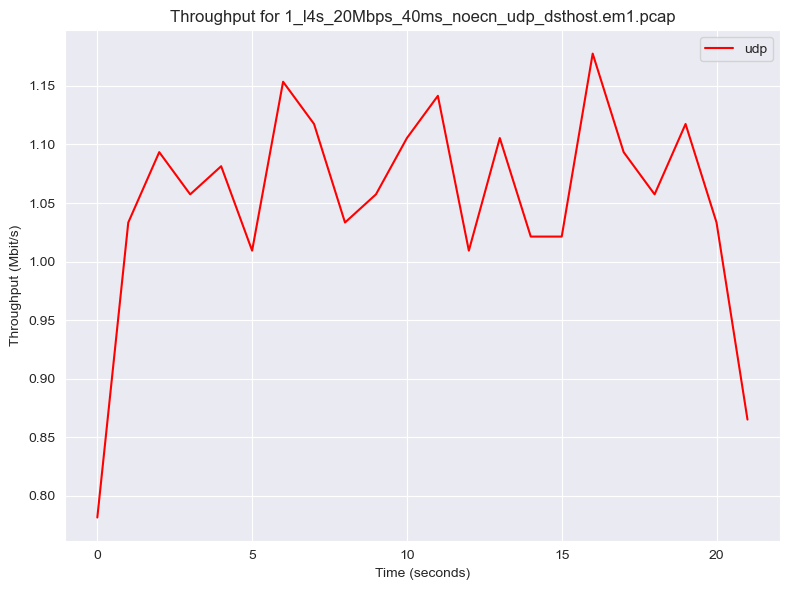

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2307072, 5102: 0, 5103: 0}
len(mbits_transferred):  18
np.mean(mbits_transferred):  1.0253653333333335
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


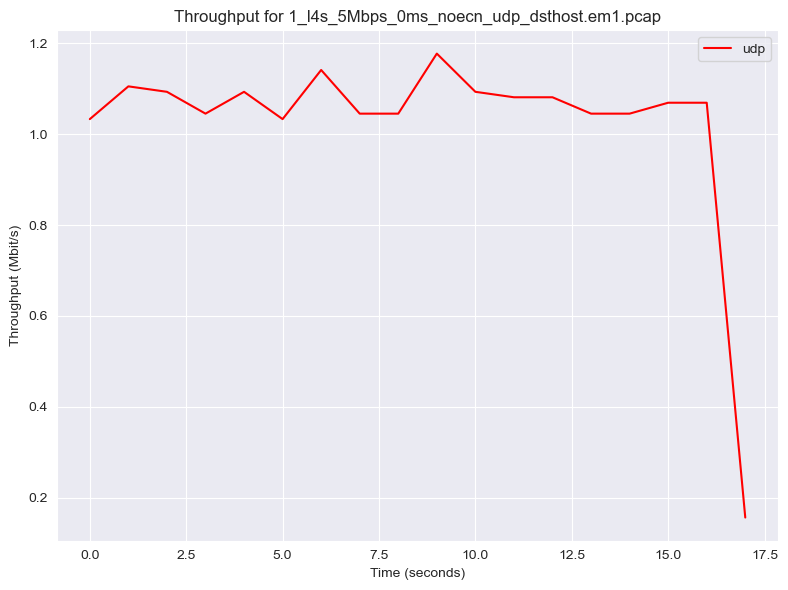

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 26387669, 5102: 0, 5103: 0}
len(mbits_transferred):  123
np.mean(mbits_transferred):  1.7162711544715448
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


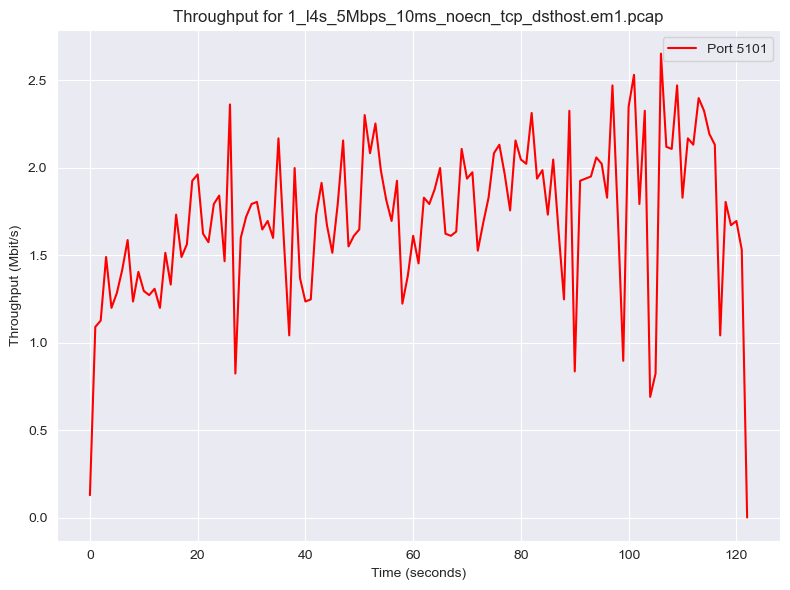

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2186972, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.029163294117647
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


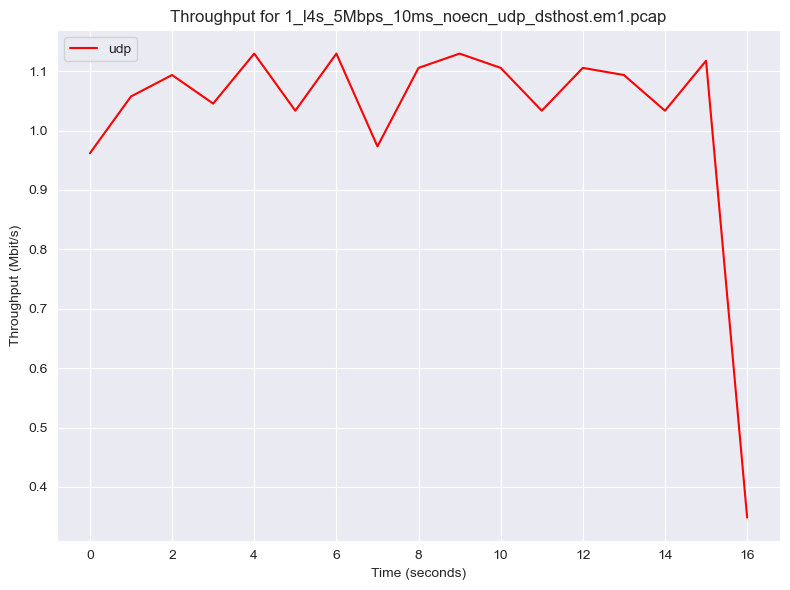

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2162940, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.017854117647059
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


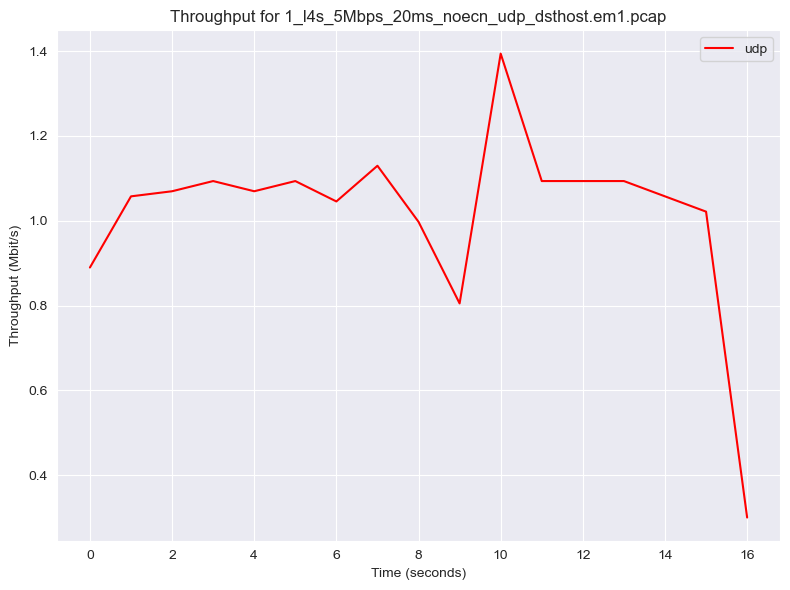

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3119654, 5102: 0, 5103: 0}
len(mbits_transferred):  24
np.mean(mbits_transferred):  1.0398846666666668
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


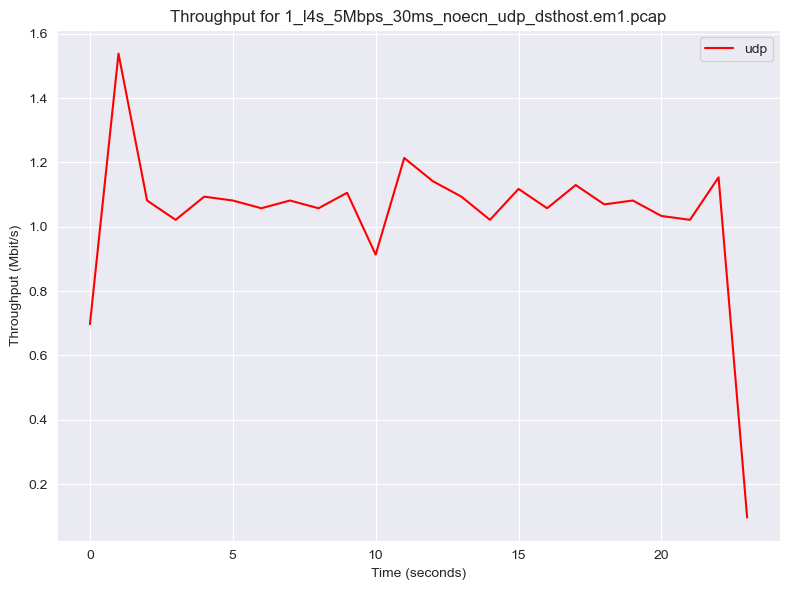

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 24209713, 5102: 0, 5103: 0}
len(mbits_transferred):  124
np.mean(mbits_transferred):  1.5619169677419356
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


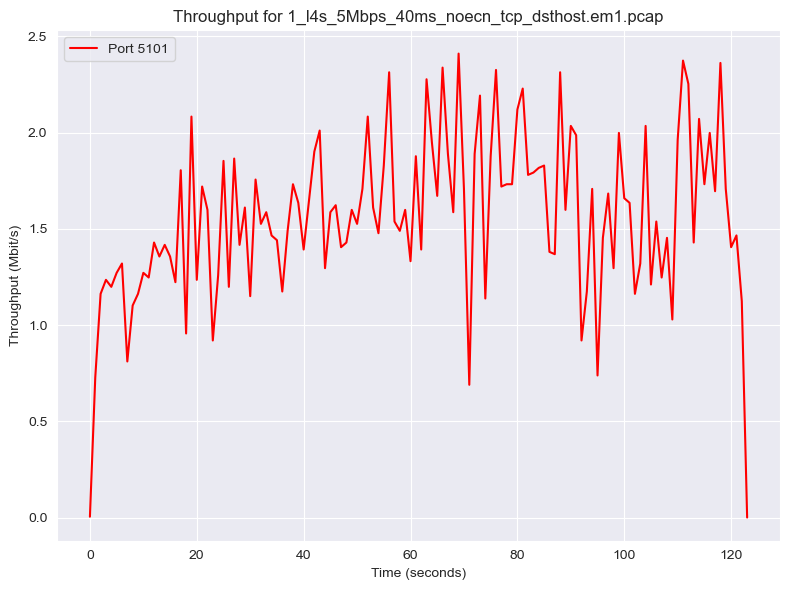

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_5Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2129896, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0023040000000003
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


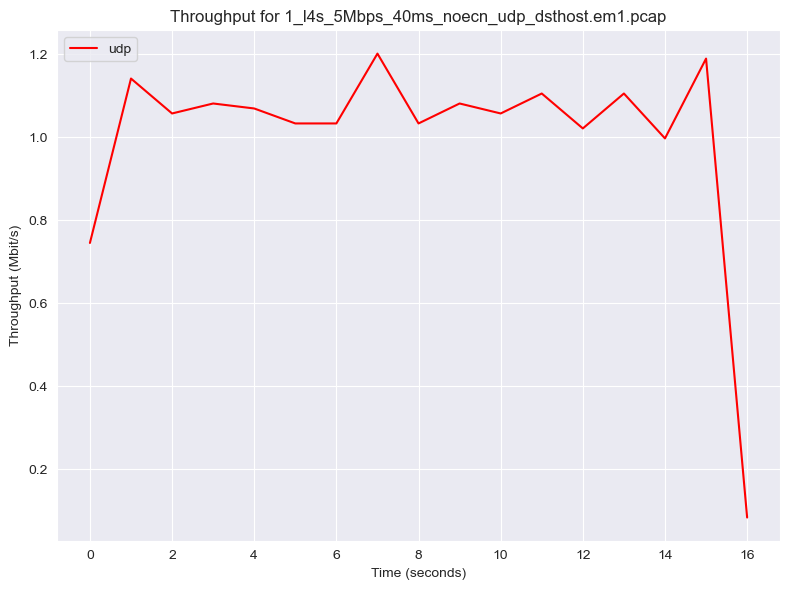

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 1416446, 5102: 0, 5103: 0}
len(mbits_transferred):  11
np.mean(mbits_transferred):  1.0301425454545454
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


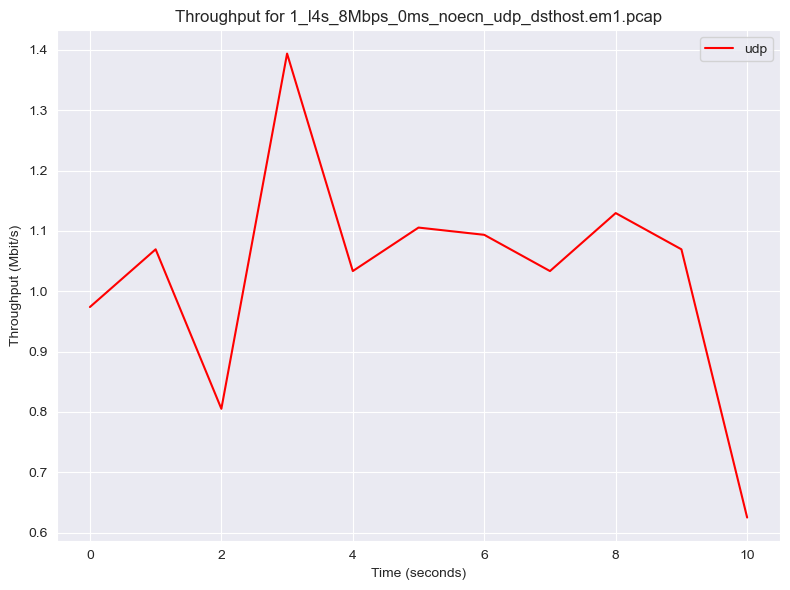

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2168888, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0206531764705882
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


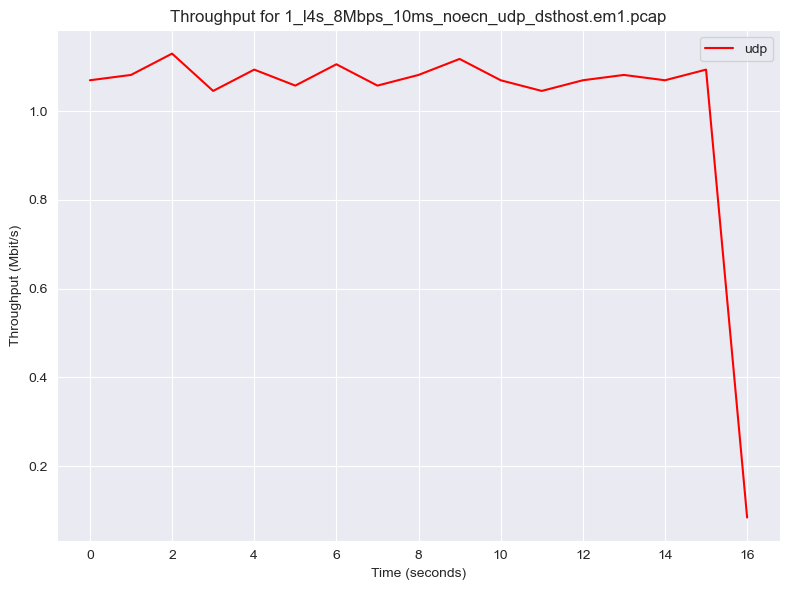

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1147, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.0030586666666666666
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2188474, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0298701176470588
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


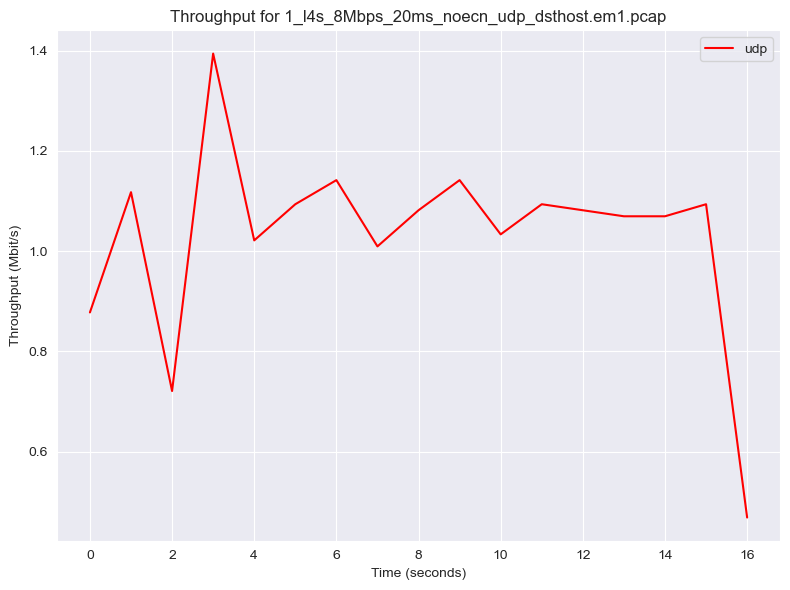

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2921450, 5102: 0, 5103: 0}
len(mbits_transferred):  23
np.mean(mbits_transferred):  1.0161565217391304
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


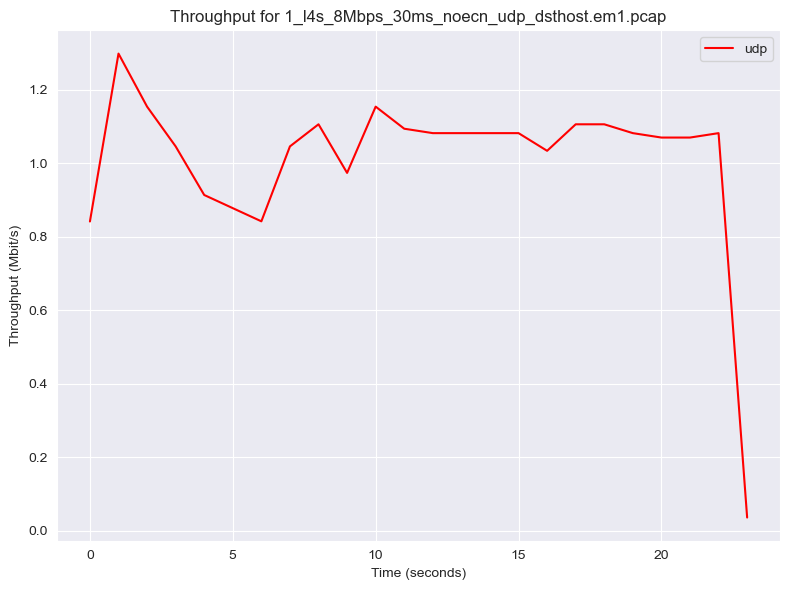

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 1_l4s_8Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2126892, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0008903529411766
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


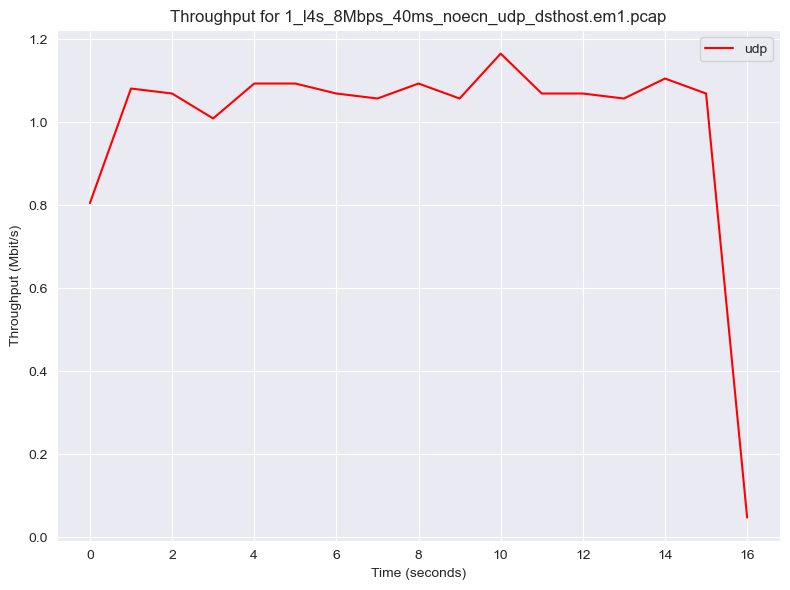

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1214, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.004856
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3884232, 5102: 0, 5103: 0}
len(mbits_transferred):  29
np.mean(mbits_transferred):  1.071512275862069
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


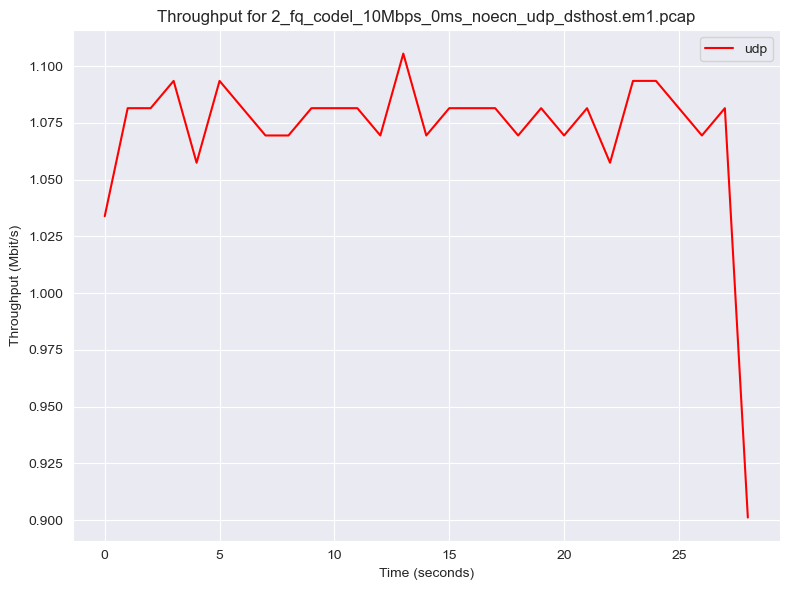

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1211, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.0032293333333333336
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3160268, 5102: 0, 5103: 0}
len(mbits_transferred):  24
np.mean(mbits_transferred):  1.0534226666666666
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


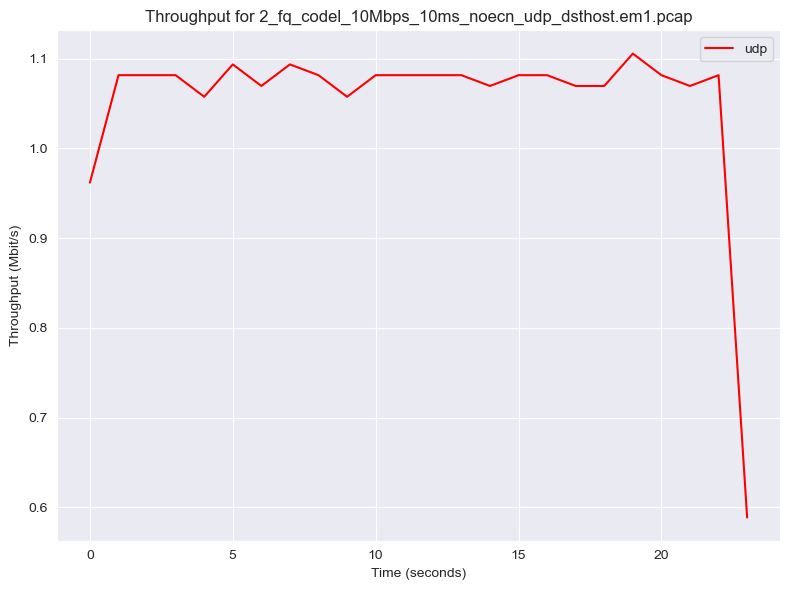

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 45443268, 5102: 0, 5103: 0}
len(mbits_transferred):  123
np.mean(mbits_transferred):  2.9556597073170727
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


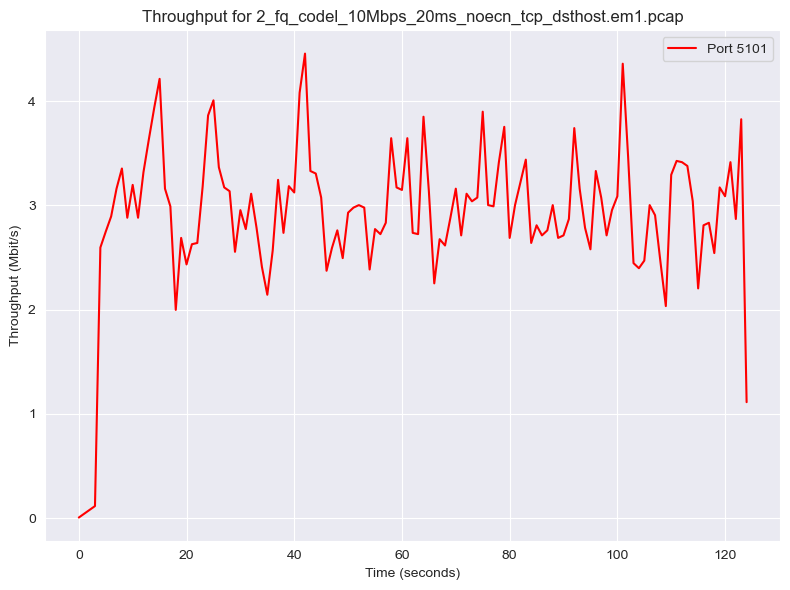

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2310136, 5102: 0, 5103: 0}
len(mbits_transferred):  18
np.mean(mbits_transferred):  1.0267271111111111
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


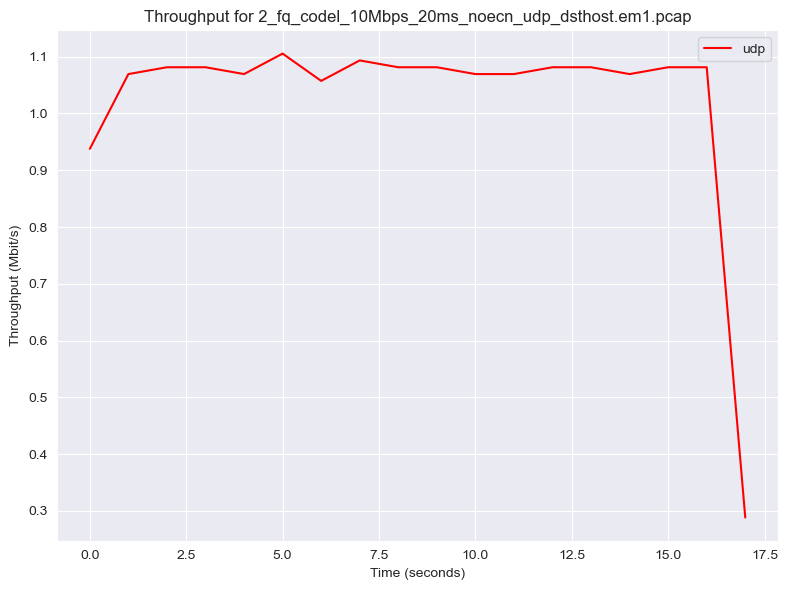

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1146, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.0030559999999999997
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 4627722, 5102: 0, 5103: 0}
len(mbits_transferred):  35
np.mean(mbits_transferred):  1.0577650285714286
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


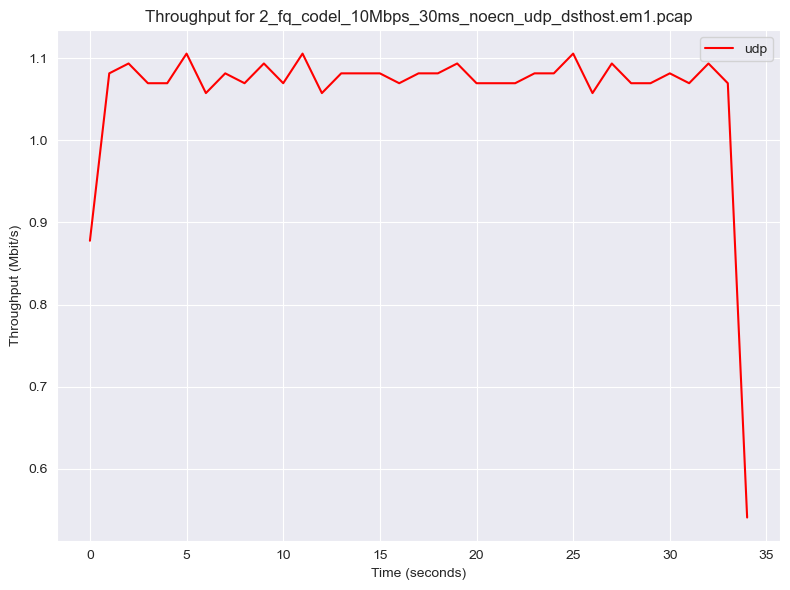

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1147, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.0030586666666666666
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_10Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 4705826, 5102: 0, 5103: 0}
len(mbits_transferred):  36
np.mean(mbits_transferred):  1.0457391111111112
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


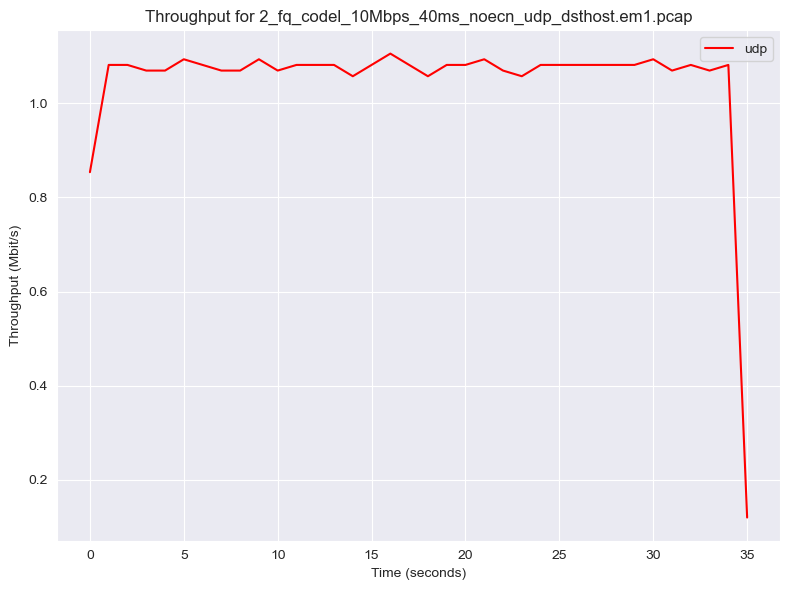

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 53073714, 5102: 0, 5103: 0}
len(mbits_transferred):  122
np.mean(mbits_transferred):  3.4802435409836066
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


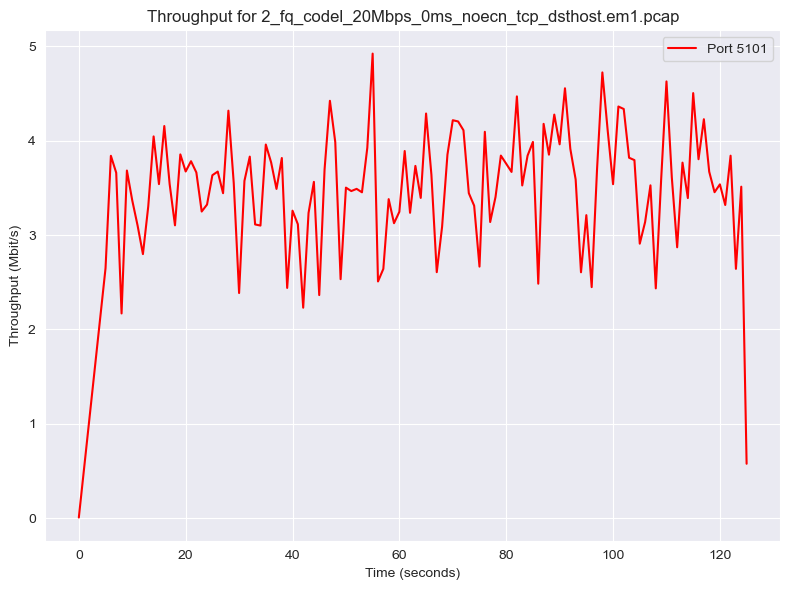

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2229028, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0489543529411764
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


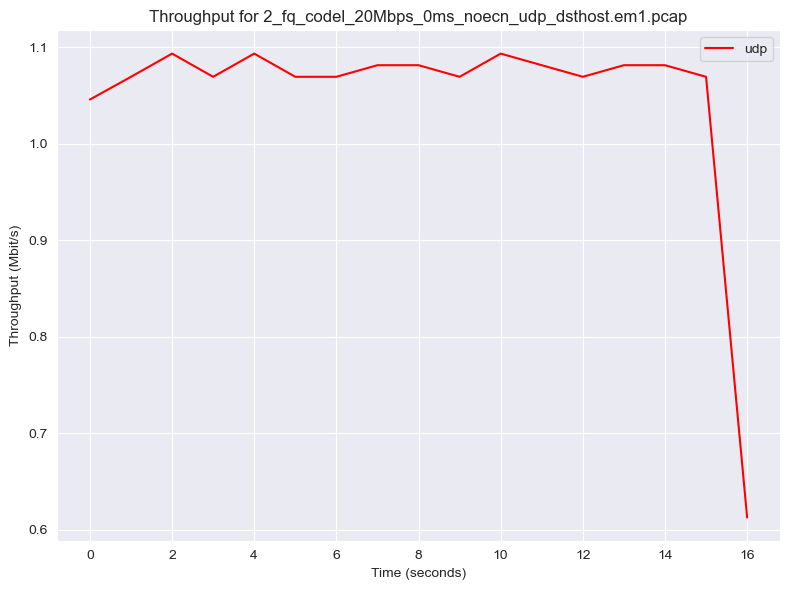

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 441, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003528
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 5411706, 5102: 0, 5103: 0}
len(mbits_transferred):  41
np.mean(mbits_transferred):  1.0559426341463412
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


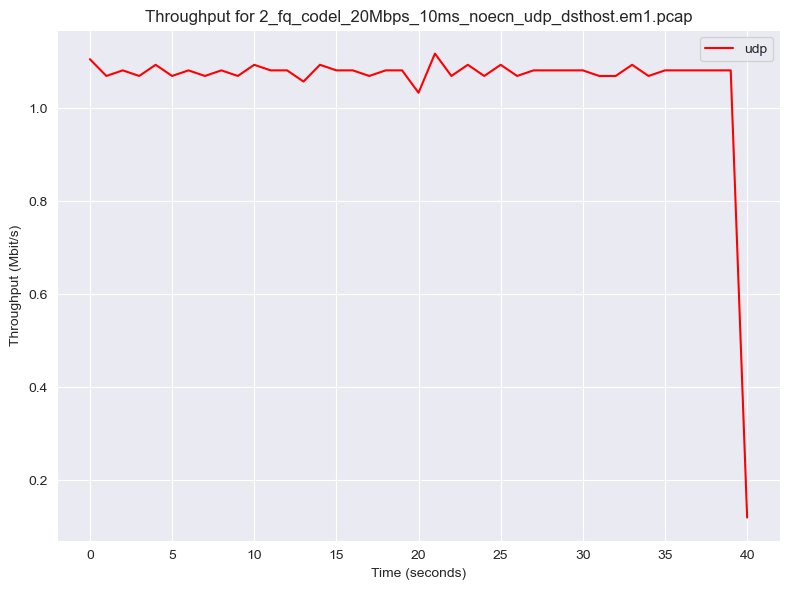

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 51786854, 5102: 0, 5103: 0}
len(mbits_transferred):  122
np.mean(mbits_transferred):  3.395859278688525
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


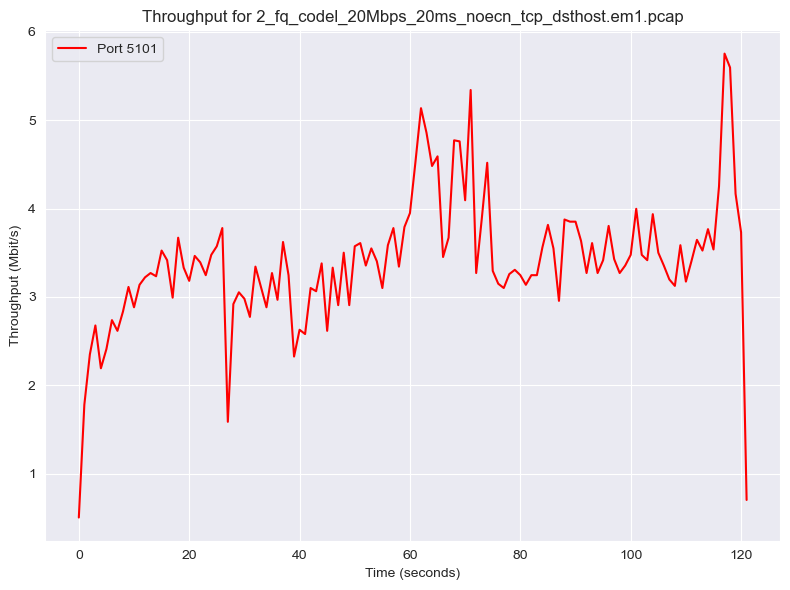

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2989040, 5102: 0, 5103: 0}
len(mbits_transferred):  23
np.mean(mbits_transferred):  1.0396660869565222
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


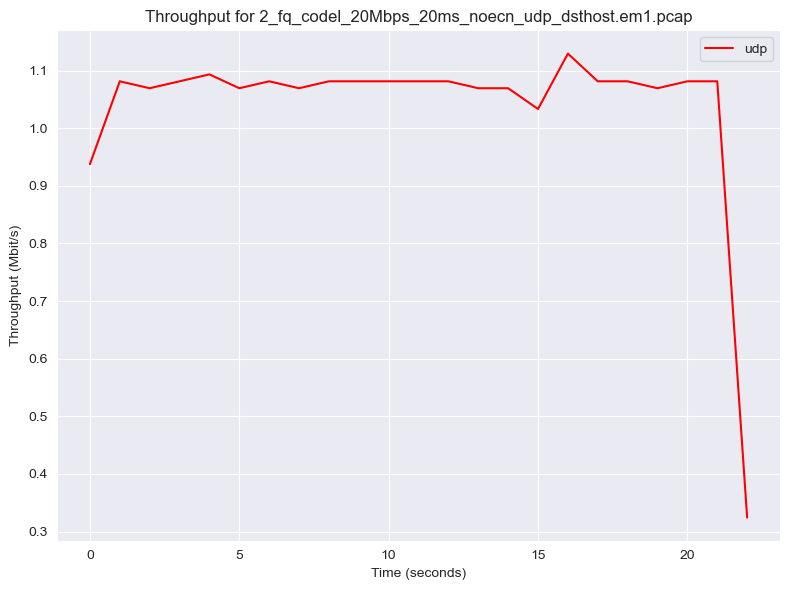

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1148, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.004592000000000001
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 4623216, 5102: 0, 5103: 0}
len(mbits_transferred):  35
np.mean(mbits_transferred):  1.0567350857142856
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


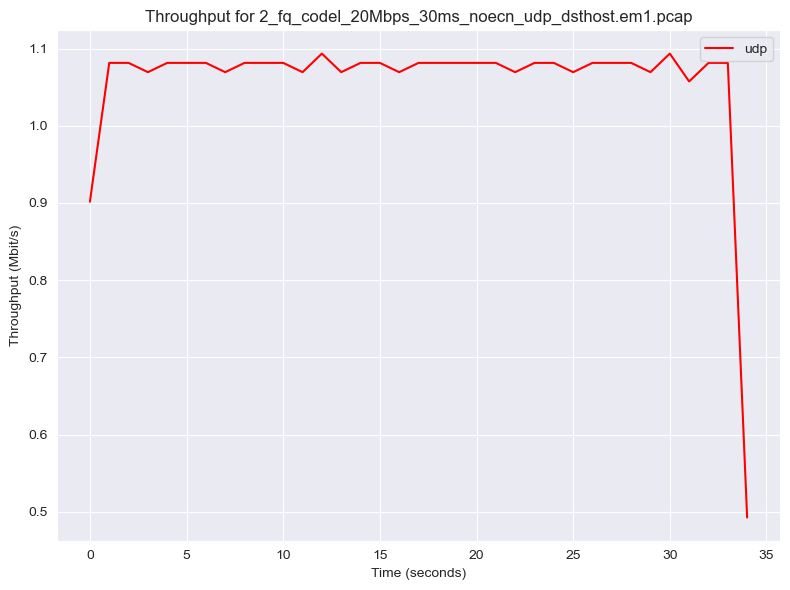

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 47589437, 5102: 0, 5103: 0}
len(mbits_transferred):  123
np.mean(mbits_transferred):  3.09524793495935
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


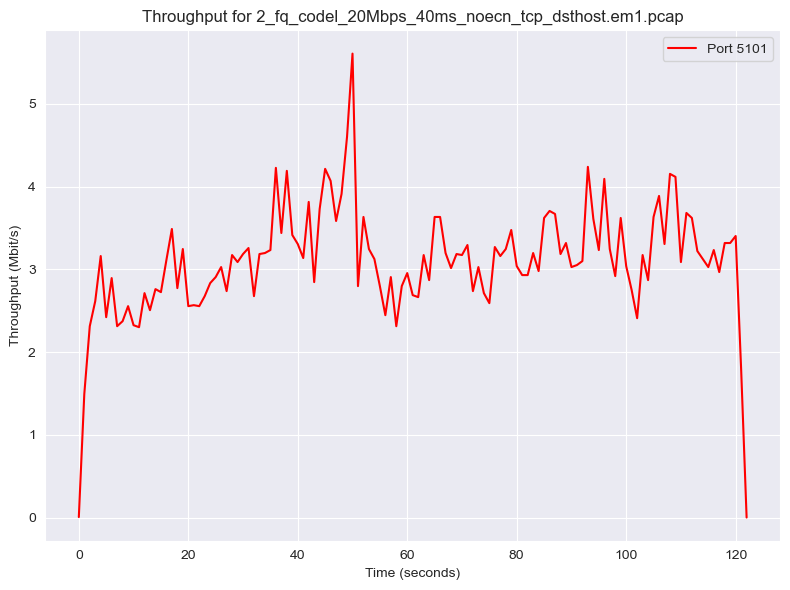

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_20Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3750554, 5102: 0, 5103: 0}
len(mbits_transferred):  29
np.mean(mbits_transferred):  1.0346355862068966
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


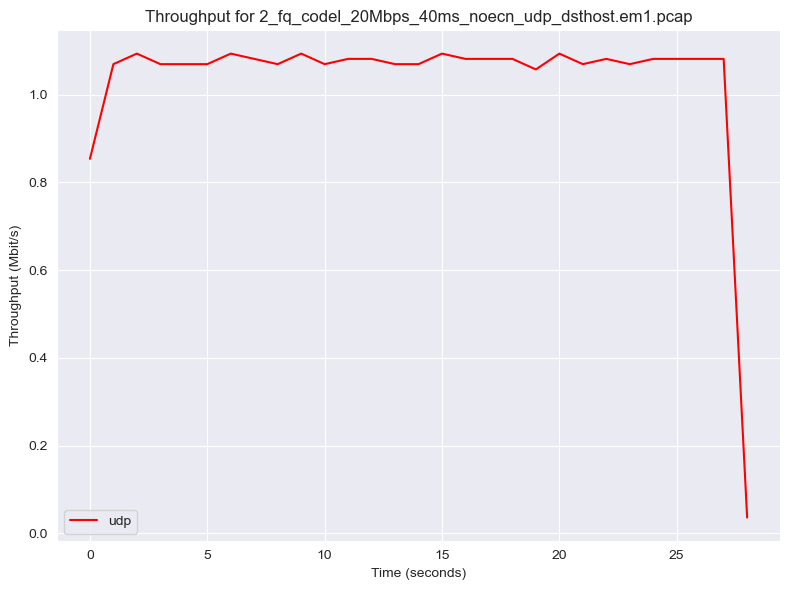

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 34554048, 5102: 0, 5103: 0}
len(mbits_transferred):  122
np.mean(mbits_transferred):  2.2658392131147536
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


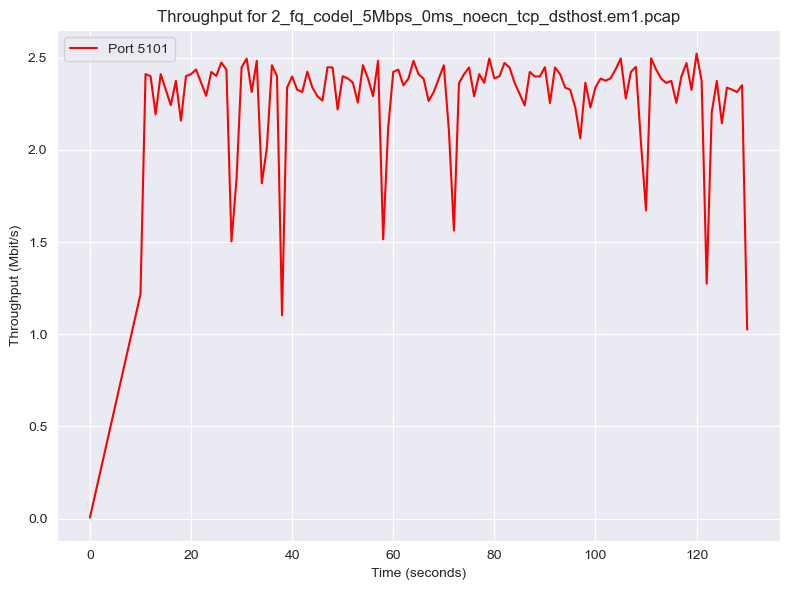

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_0ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3199320, 5102: 0, 5103: 0}
len(mbits_transferred):  24
np.mean(mbits_transferred):  1.06644
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


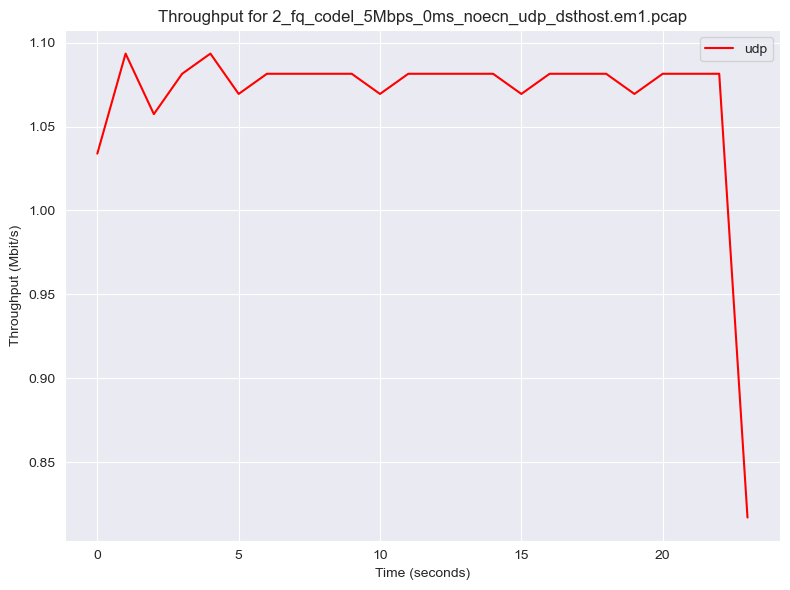

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_10ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 32884333, 5102: 0, 5103: 0}
len(mbits_transferred):  121
np.mean(mbits_transferred):  2.1741707768595044
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


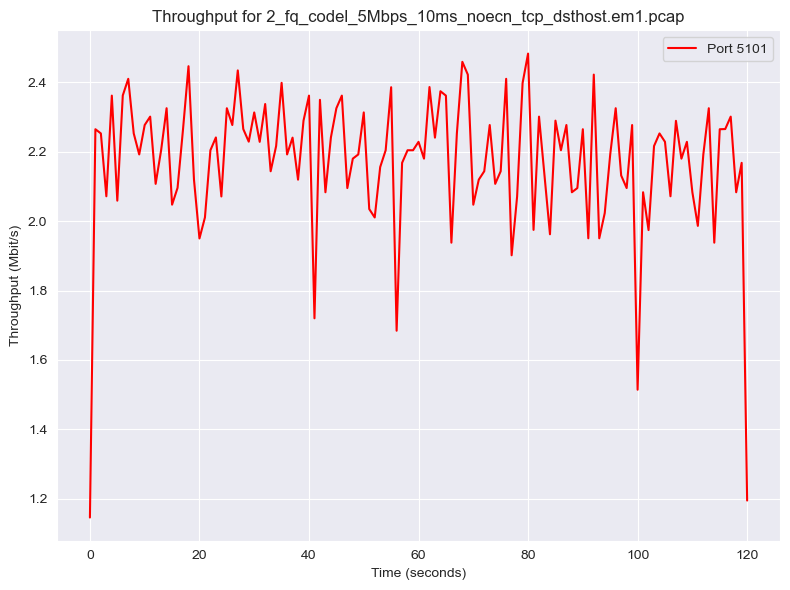

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_10ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 3037104, 5102: 0, 5103: 0}
len(mbits_transferred):  23
np.mean(mbits_transferred):  1.056384
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


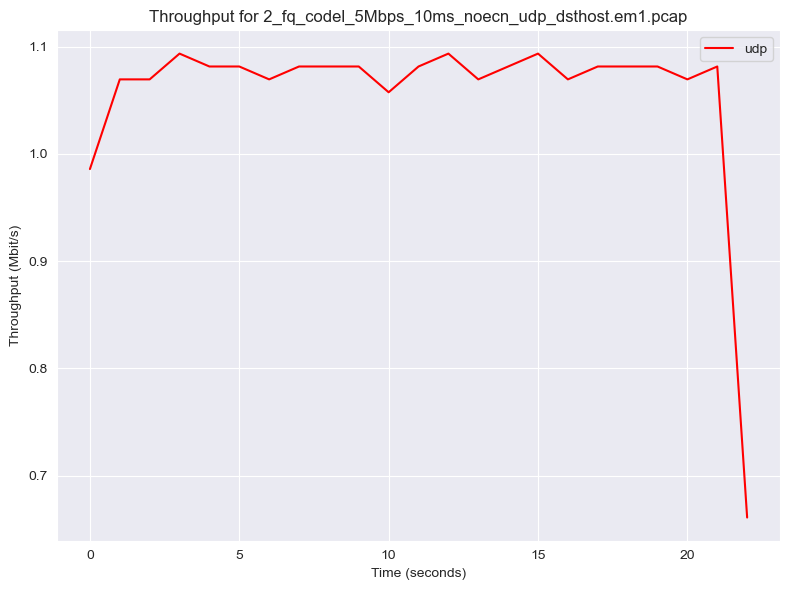

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_20ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 375, 5102: 0, 5103: 0}
len(mbits_transferred):  1
np.mean(mbits_transferred):  0.003
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_20ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2185470, 5102: 0, 5103: 0}
len(mbits_transferred):  17
np.mean(mbits_transferred):  1.0284564705882353
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


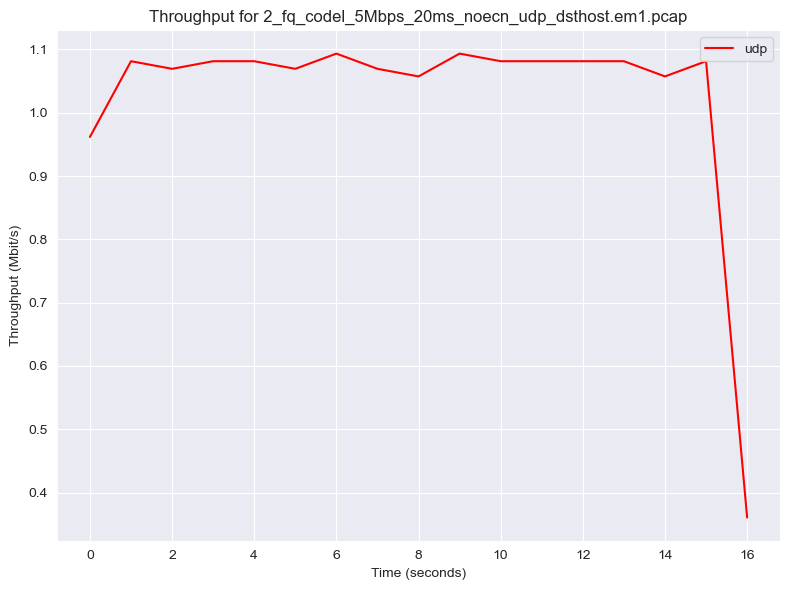

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_30ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1213, 5102: 0, 5103: 0}
len(mbits_transferred):  2
np.mean(mbits_transferred):  0.004852
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_30ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 2302626, 5102: 0, 5103: 0}
len(mbits_transferred):  18
np.mean(mbits_transferred):  1.0233893333333333
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


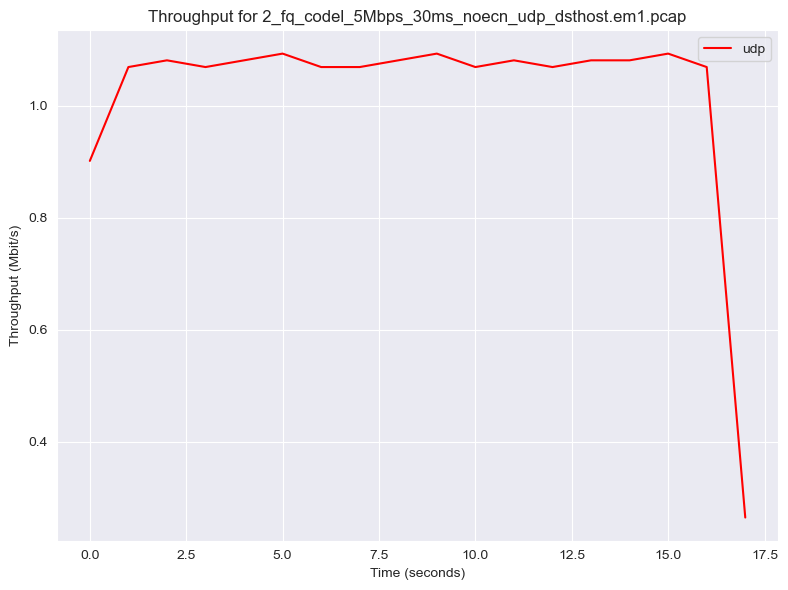

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_40ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 1212, 5102: 0, 5103: 0}
len(mbits_transferred):  3
np.mean(mbits_transferred):  0.003232
Port 5101 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_5Mbps_40ms_noecn_udp_dsthost.em1.pcap_throughput: {5101: 6207826, 5102: 0, 5103: 0}
len(mbits_transferred):  47
np.mean(mbits_transferred):  1.0566512340425531
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


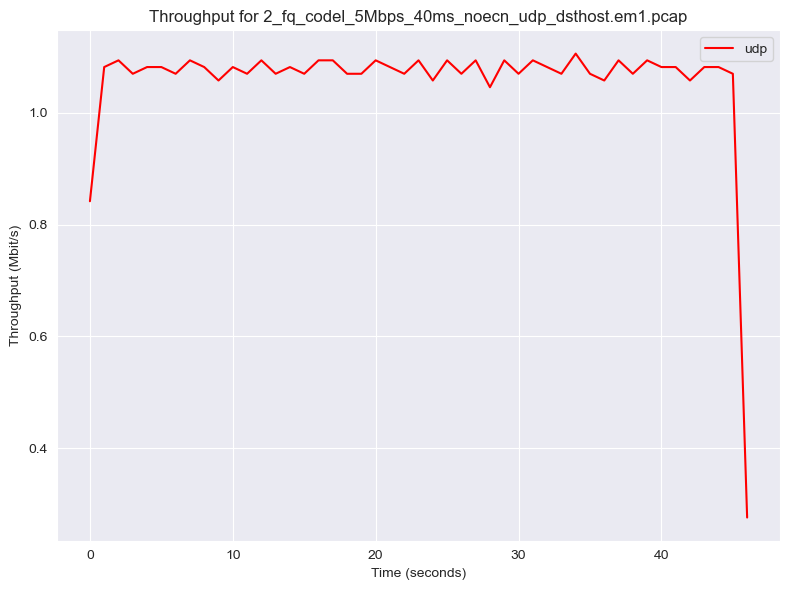

len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5102 has low throughput. Skipping...
len(mbits_transferred):  0
np.mean(mbits_transferred):  nan
Port 5103 has low throughput. Skipping...
Total throughput for 2_fq_codel_8Mbps_0ms_noecn_tcp_dsthost.em1.pcap_throughput: {5101: 43200225, 5102: 0, 5103: 0}
len(mbits_transferred):  121
np.mean(mbits_transferred):  2.856213223140496
Port 5101 has good throughput. Plotting...
Directory already exists: ../data/data_2025-03-19-01-12-25\Graphs


In [ ]:
# Plot throughput for each pcap file
for filename, filepath in zip(filenames, filepaths):
    plot_throughput_with_siftr(
        file_path=filepath,
        ycolumn="Throughput (Mbit/s)",
        title=f"Throughput for {filename}",
        xlabel="Time (seconds)",
        ylabel="Throughput (Mbit/s)",
        filename=f"{filename}_throughput",
        graph_directory=graph_directory
    )